In [29]:
from statistics import mean
import gc
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
# from utils import *
from tqdm import tqdm
tqdm.pandas(desc='pandas bar')
import warnings
import time
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
warnings.filterwarnings('ignore')

In [30]:
import time

# original all columns were int64 with max/min being +/-9223372036854775808, too big
# now if a col's max & min within int16's max & min, then change the col type to int16, and so on

def reduce_mem(df):
    """reduce memory"""
    starttime = time.time()
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if pd.isnull(c_min) or pd.isnull(c_max):
                continue
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    end_mem = df.memory_usage().sum() / 1024**2
    print('-- Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction),time spend:{:2.2f} min'
          .format(end_mem, 100*(start_mem-end_mem)/start_mem, (time.time()-starttime)/60))
    
    return df

# Exploratory Data Analysis

In [ ]:
df = pd.read_csv('ctr_train.csv')

In [84]:
# extract data from day1-6 to be our train dataset
df = df[df["pt_d"]!=7]

In [85]:
# extract start and end time of users' active time by mobile phone (originally this col was object type, contains consecutive active hours in a day)
df['online_start'] = df.communication_onlinerate.progress_apply(lambda s: int(s.split('^')[0]))
df['online_end'] = df.communication_onlinerate.progress_apply(lambda s: int(s.split('^')[-1]))
del df['communication_onlinerate']

# delete app_score due to all zeros
del df['app_score']

pandas bar: 100%|██████████| 2570068/2570068 [00:05<00:00, 448698.75it/s]


In [93]:
# divide features into three categories except for label and pt_d
# user-related features
u_feats = ['uid', 'age', 'city', 'city_rank', 'device_name', 'device_size', 'career', 'gender', 
           'net_type', 'residence', 'emui_dev', 'list_time', 'device_price', 
           'up_life_duration', 'up_membership_grade', 'membership_life_duration', 'consume_purchase', 
           'communication_avgonline_30d', 'online_start', 'online_end']

# advertisement-related features
ad_feats = ['slot_id', 'task_id', 'adv_id', 'adv_prim_id', 'dev_id', 'inter_type_cd', 'indu_name', 
           'creat_type_cd']

# app-related features
app_feats = ['spread_app_id', 'tags', 'app_first_class', 'app_second_class','his_app_size', 'his_on_shelf_time']

type_col = []
for col in df.columns:
    if col in u_feats:
        type_col.append('user-related')
    elif col in ad_feats:
        type_col.append('ad-related')
    elif col in app_feats:
        type_col.append('app-related')
    else:
        type_col.append(col)

In [94]:
featdescription = pd.DataFrame()
featdescription['type'] = type_col
featdescription['feature'] = df.columns
featdescription['num_unique'] = df.nunique().values
featdescription['max'] = [df[col].max() for col in df.columns]
featdescription['min'] = [df[col].min() for col in df.columns]
featdescription['median'] = [df[col].median() for col in df.columns]
# all missing values in the dataset are labeled as -1 
# missing proportion of the feature
featdescription['missing_prop'] = ((df == -1).sum() / len(df)).values * 100
# which level of the feature has the max counts
featdescription['max_count_level'] = [df[col].value_counts().idxmax() for col in df.columns]
# what proportion does the max count level account for 
featdescription['max_count_level_prop'] = [df[col].value_counts().values[0] / len(df) for col in df.columns]

featdescription.set_index(['type','feature']).sort_index(ascending=True)

num_unique        max        min  \
type         feature                                                         
ad-related   adv_id                             5461     8765.0     1001.0   
             adv_prim_id                         168      291.0      101.0   
             creat_type_cd                         8        9.0        2.0   
             dev_id                               63       81.0       11.0   
             indu_name                            36       51.0       11.0   
             inter_type_cd                         4        5.0        2.0   
             slot_id                              13       23.0       11.0   
             task_id                            5176     8334.0     1001.0   
app-related  app_first_class                       3        4.0        2.0   
             app_second_class                     18       29.0       11.0   
             his_app_size                         21       21.0       -1.0   
             his_on_shelf_time                     3        2.0       -1.0   
             spread_app_id                        79       99.0       11.0   
             tags                                 32       47.0       11.0   
label        label                                 2        1.0        0.0   
pt_d         pt_d                                  6        6.0        1.0   
user-related age                                   8        7.0       -1.0   
             career                                9       10.0        2.0   
             city                                344      444.0      101.0   
             city_rank                             4        5.0        2.0   
             communication_avgonline_30d          14       13.0       -1.0   
             consume_purchase                      9       10.0        2.0   
             device_name                         190      343.0      101.0   
             device_price                          8        7.0       -1.0   
             device_size                         304      948.0      101.0   
             emui_dev                             22       34.0       11.0   
             gender                                3        4.0        2.0   
             list_time                            38       42.0       -2.0   
             membership_life_duration             15       20.0       -1.0   
             net_type                              6        7.0        2.0   
             online_end                           20       23.0       -1.0   
             online_start                         25       23.0       -1.0   
             residence                            37       47.0       11.0   
             uid                              974499  4060480.0  1000001.0   
             up_life_duration                     21       20.0       -1.0   
             up_membership_grade                   4        3.0       -1.0   

                                             median  missing_prop  \
type         feature                                                
ad-related   adv_id                          5171.0      0.000000   
             adv_prim_id                      200.0      0.000000   
             creat_type_cd                      2.0      0.000000   
             dev_id                            40.0      0.000000   
             indu_name                         44.0      0.000000   
             inter_type_cd                      4.0      0.000000   
             slot_id                           17.0      0.000000   
             task_id                         4923.0      0.000000   
app-related  app_first_class                    3.0      0.000000   
             app_second_class                  15.0      0.000000   
             his_app_size                       6.0     14.076048   
             his_on_shelf_time                  2.0     14.076048   
             spread_app_id                     58.0      0.000000   
             tags                         

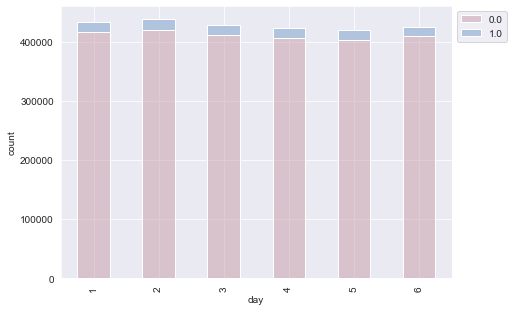

In [ ]:
# count by day: almost equal distribution across the 7-day period
sns.set_style("darkgrid")
# make sure pt_d distribution is correct and same as it was before sampling 
day_df = df.groupby(['pt_d', 'label'])['pt_d'].count().unstack('label').fillna(0);
day_df[[0, 1]].plot(kind='bar', stacked=True, figsize=(7,5),color = ['#c79da980','lightsteelblue'])
plt.xlabel("day")
plt.ylabel("count")
plt.legend(loc='best',bbox_to_anchor=(1, 1));

<Figure size 2160x2160 with 0 Axes>

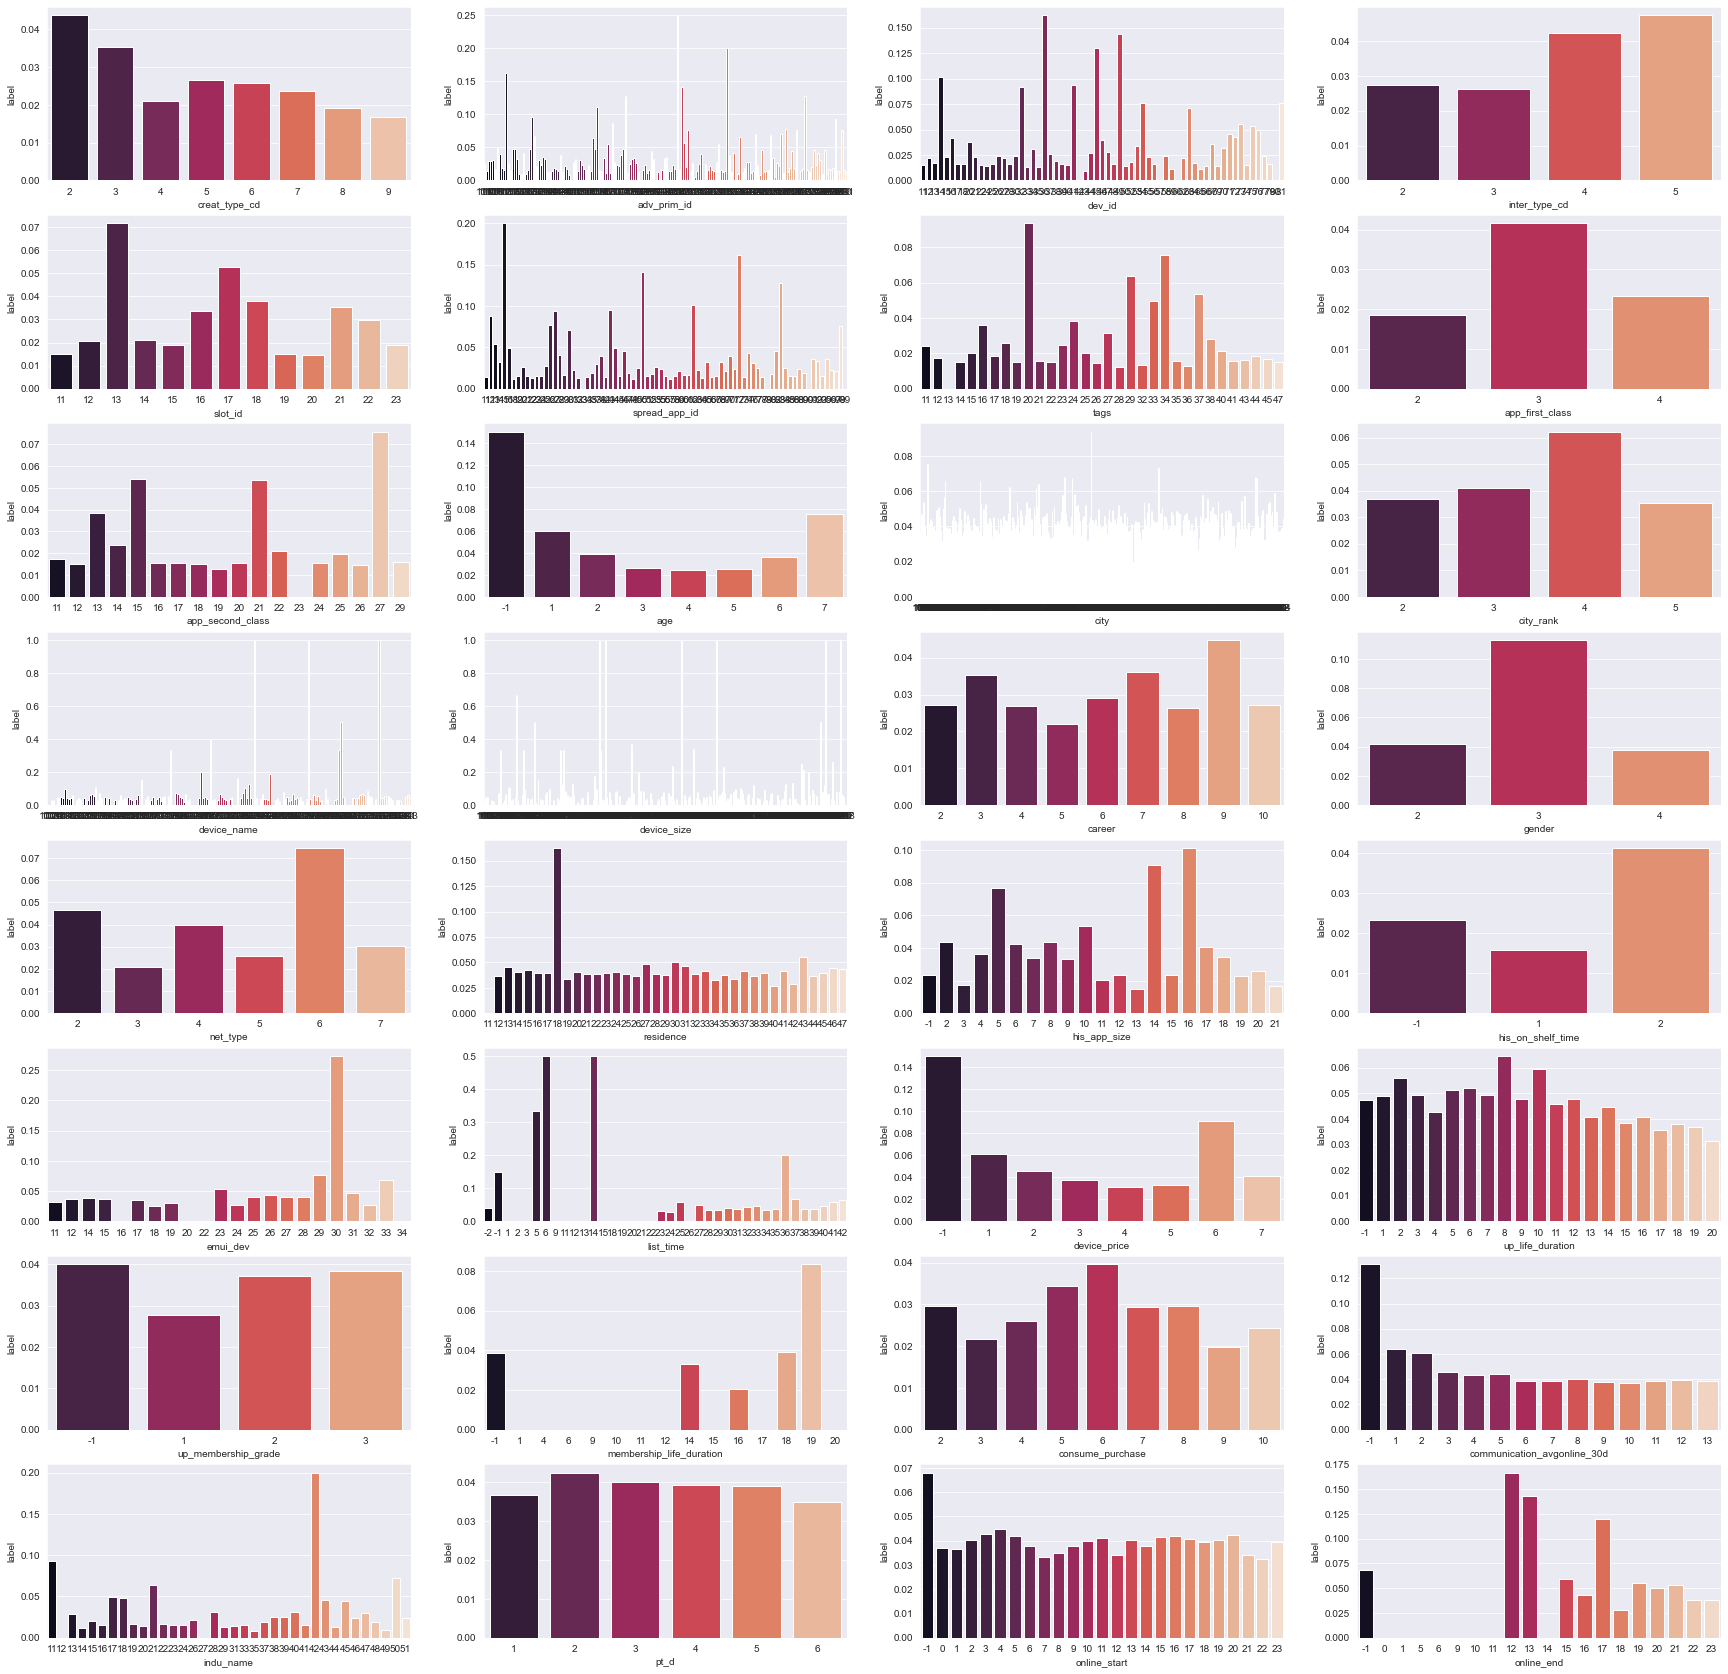

In [ ]:
# barplot of CTR vs. each categorical variable's levels
# CTR is calculated by the mean of label
plt.figure(figsize=(30, 30))
cols = df.drop(columns = ['label', 'uid', 'task_id', 'adv_id']).columns

plt.figure(figsize=(30, 30))
i = 1
for col in cols:
    pdf = df.groupby(col)['label'].mean().reset_index();
    plt.subplot(8,4,i)
    i += 1
    sns.barplot(x=col, y='label', data=pdf, palette = "rocket")

plt.show()

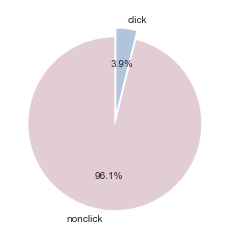

In [ ]:
# click vs nonclick proportion comparison
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
labels = ["nonclick","click"]
sizes = df.label.value_counts().values
explode=[0.1,0]
colors = ['#c79da980','lightsteelblue']
patches, texts,autotexts= plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct="%1.1f%%", startangle=90)

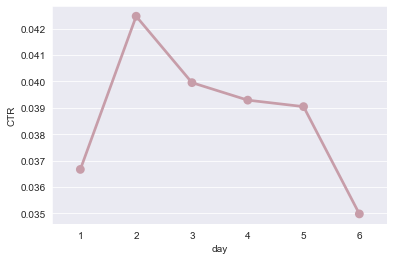

In [ ]:
# CTR trend from day1 to day6
click_trend = df[["label","pt_d"]].groupby("pt_d",as_index=False).agg(mean)
sns.pointplot(x="pt_d", y="label", data=click_trend,color = "#c79da980")
plt.xlabel("day")
plt.ylabel("CTR")
plt.show()

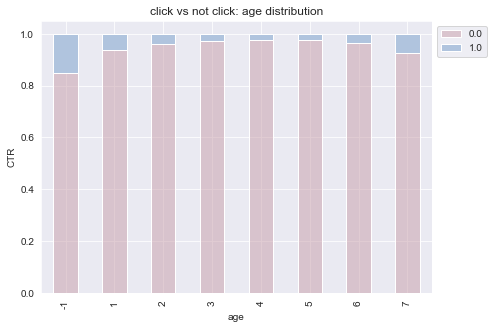

In [ ]:
# CTR by age group
table = pd.crosstab(df.age,df.label);
ax = table.div(table.sum(1).astype(float), axis=0).plot(kind='bar',stacked=True,color = ['#c79da980','lightsteelblue'],figsize=(7,5));
plt.title('click vs not click: age distribution');
plt.legend(loc='best',bbox_to_anchor=(1, 1))
plt.xlabel('age');
plt.ylabel('CTR');

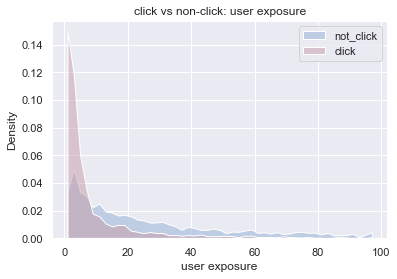

In [ ]:
# user exposure: click vs nonclick
# user exposure means how many ads one user was exposed to 
nonclick_user_exposure = df[df["label"]==0][["uid","task_id"]].groupby("task_id").agg(len)["uid"]
click_user_exposure = df[df["label"]==1][["uid","task_id"]].groupby("task_id").agg(len)["uid"]

sns.set(rc = {'figure.figsize':(6,4)})
bins = np.arange(0,100,2)
sns.histplot(nonclick_user_exposure,stat='density',bins=bins,label="not_click", color='lightsteelblue',ec='w',element="poly");
sns.histplot(click_user_exposure,stat='density',bins=bins,label="click", color='#c79da9ff', alpha = 0.5, ec='w',element="poly");
plt.xlabel("user exposure")
plt.title("click vs non-click: user exposure");
plt.legend();

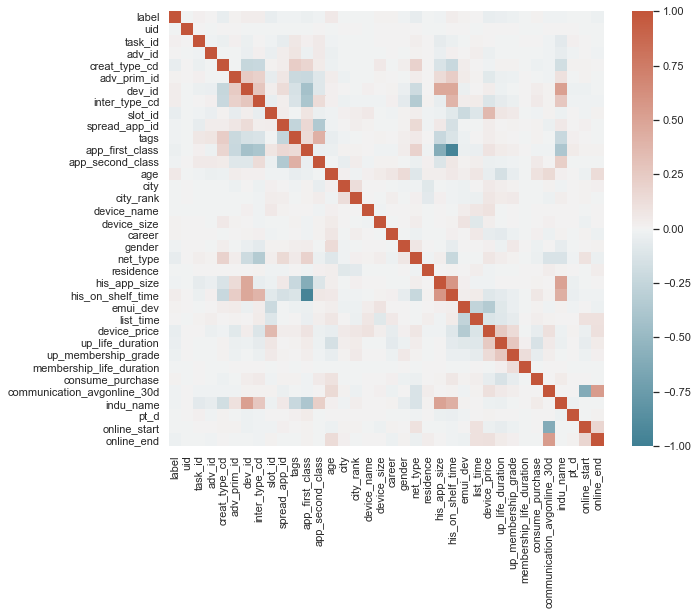

In [ ]:
# correlation heatmap of all features
plt.rcParams["figure.figsize"] = [10, 8]
corr_heatmap = sns.heatmap(df.corr(),vmin=-1, vmax=1,cmap=sns.diverging_palette(220, 20, as_cmap=True),square=True);

## Preprocess

In [96]:
df = pd.read_csv('ctr_train.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [97]:
# 36 features including response variables
df.shape

(3000000, 36)

In [98]:
gc.collect()

382

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 36 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   label                        float64
 1   uid                          int64  
 2   task_id                      int64  
 3   adv_id                       int64  
 4   creat_type_cd                int64  
 5   adv_prim_id                  int64  
 6   dev_id                       int64  
 7   inter_type_cd                int64  
 8   slot_id                      int64  
 9   spread_app_id                int64  
 10  tags                         int64  
 11  app_first_class              int64  
 12  app_second_class             int64  
 13  age                          int64  
 14  city                         int64  
 15  city_rank                    int64  
 16  device_name                  int64  
 17  device_size                  int64  
 18  career                       int64  
 19  

The whole features can be classified into two groups: Ordinal Data and Simple Categorical Data. 

In [100]:
df.columns

Index(['label', 'uid', 'task_id', 'adv_id', 'creat_type_cd', 'adv_prim_id',
       'dev_id', 'inter_type_cd', 'slot_id', 'spread_app_id', 'tags',
       'app_first_class', 'app_second_class', 'age', 'city', 'city_rank',
       'device_name', 'device_size', 'career', 'gender', 'net_type',
       'residence', 'his_app_size', 'his_on_shelf_time', 'app_score',
       'emui_dev', 'list_time', 'device_price', 'up_life_duration',
       'up_membership_grade', 'membership_life_duration', 'consume_purchase',
       'communication_onlinerate', 'communication_avgonline_30d', 'indu_name',
       'pt_d'],
      dtype='object')

### Ordinal Data

In [101]:
# Get a list containing all features
column_name = df.columns

In [102]:
# According to the definition of each features, ordinal data is selected.
# In fact, the ordinal features like age has already been transformed into buckets by data source provider, which should have been a continuous value 
# based on common sense. e.g. Age = 1 represents [10,20)
# However, Some of the features have too many values, thus require more preprocessing work

Ordinal_Data = ['age','city_rank','device_size','his_app_size','his_on_shelf_time','list_time','device_price','up_life_duration',
                'up_membership_grade','membership_life_duration','consume_purchase','communication_avgonline_30d']


In [103]:
# Adjusted Label encoding by dictionary mapping
# this function will only be applied to ordinal columns which have a few unique values that do not need to be divided into bins
def ordinal_data_encoding(df_series):
  # lst_1 find all unique values in a column and sort them in ascending order
  unique_value = df_series.unique()
  lst_1 = np.sort(unique_value).tolist()
  # Try except avoids modifying -1, which represents nan and does not need to be encoded.
  try:
    lst_1.remove(-1)
  except:
    print('there is no -1')
  # lst_2 is 0,1,2 ... until (len(lst_1)-1)
  lst_2 = range(len(lst_1))
  # create a dictionary that maps lst_2 new values to lst_1 original values
  enc_dict = dict(zip(lst_1,lst_2))
  # -1 in original dataset should still be -1 after mapping
  enc_dict[-1]=-1
  return df_series.map(enc_dict)

In [ ]:
# A big reason why we want to keep the ordinality of data is that even if tree model will do binary split on continuous variables, 
# we do not want to influence the importance of each feature.

In [104]:
#age
df['age'].value_counts()

 5    840423
 6    834446
 7    572087
 4    543955
 3     99940
 2     88826
 1     12481
-1      7842
Name: age, dtype: int64

In [105]:
#city_rank
df['city_rank'] = ordinal_data_encoding(df.city_rank)

there is no -1


In [106]:
#device_size 
df['device_size'] = ordinal_data_encoding(df.device_size)

there is no -1


In [107]:
# cut device_size into 10 bins because it has too much levels
print("before ",len(df.device_size.unique()))
df['device_size'] = pd.cut(df.device_size, bins=10, labels=False)
print("after ", len(df.device_size.unique()))

before  317
after  10


In [108]:
#his_app_size
# Cut his_app_size except -1 into 10 bins 
print("before ",len(df.his_app_size.unique()))
df['his_app_size'] = pd.cut(df[df.his_app_size!=-1]['his_app_size'], bins=10, labels=False)
print("after ",len(df.his_app_size.unique()))

before  21
after  11


In [109]:
# Keep -1 in this feature
df['his_app_size'] = df['his_app_size'].fillna(-1)

In [110]:
#his_on_shelf_time
df['his_on_shelf_time'] = ordinal_data_encoding(df.his_on_shelf_time)

In [111]:
#list_time
# Cut list_time into several intervals (Half year)
df['list_time'] = pd.cut(df[(df.list_time!=-1)&(df.list_time!=-2)]['list_time'],bins=[0,6,12,18,24,30,36,42])
# Convert this interval to string type for further encoding
df.list_time = df.list_time.astype('str')
# Encoding dictionary
enc_dict = {'(0, 6]':0,'(6, 12]':1,'(12, 18]':2,'(18, 24]':3,'(24, 30]':4,'(30, 36]':5,'(36, 42]':6}
# Do encoding
df['list_time']=df['list_time'].map(enc_dict)
# Fill the nan value with -1 as before
df['list_time'] = df['list_time'].fillna(-1)

In [112]:
#device_price
df['device_price'] = ordinal_data_encoding(df.device_price)

In [113]:
#up_life_duration
# Cut this feature into 10 bins except -1
df['up_life_duration'] = pd.cut(df[df.up_life_duration!=-1]['up_life_duration'], bins=10, labels=False)
df['up_life_duration'] = df['up_life_duration'].fillna(-1)

In [114]:
#up_membership_grade
df['up_membership_grade']=ordinal_data_encoding(df.up_membership_grade)

In [115]:
#membership_life_duration
df.membership_life_duration.value_counts()

-1     2997520
 18       2311
 16         60
 14         40
 19         19
 20         15
 12         12
 11          8
 17          5
 9           3
 6           2
 7           1
 1           1
 15          1
 4           1
 10          1
Name: membership_life_duration, dtype: int64

In [116]:
# Most of this feature is -1, i.e. nan value, thus we drop this column
df.drop('membership_life_duration',inplace=True,axis=1)

In [117]:
#consume_purchase
df['consume_purchase']=ordinal_data_encoding(df.consume_purchase)

there is no -1


In [118]:
#communication_avgonline_30d
df['communication_avgonline_30d']=ordinal_data_encoding(df.communication_avgonline_30d)

In [119]:
Ordinal_Data

['age',
 'city_rank',
 'device_size',
 'his_app_size',
 'his_on_shelf_time',
 'list_time',
 'device_price',
 'up_life_duration',
 'up_membership_grade',
 'membership_life_duration',
 'consume_purchase',
 'communication_avgonline_30d']

In [120]:
# Remove membership_life_duration from ordinal data list since we have dropped it
Ordinal_Data.remove('membership_life_duration')
# Slice the dataframe 
df_ord = df[Ordinal_Data]

In [121]:
df.shape

(3000000, 35)

In [122]:
df_ord.shape

(3000000, 11)

### Categorical Data

In [74]:
# Get the categorical data list
Category_Data = list(set(list(df.columns))-set(Ordinal_Data))

In [75]:
Category_Data

['label',
 'adv_prim_id',
 'inter_type_cd',
 'task_id',
 'app_first_class',
 'creat_type_cd',
 'slot_id',
 'pt_d',
 'spread_app_id',
 'gender',
 'indu_name',
 'app_second_class',
 'online_end',
 'online_start',
 'city',
 'uid',
 'tags',
 'career',
 'residence',
 'dev_id',
 'device_name',
 'adv_id',
 'emui_dev',
 'net_type']

In [76]:
# slice the data and put them into a new dataframe
df_cat = df[Category_Data]

In [ ]:
# directly perform label encoding on features since they all do not have -1
for feat in tqdm(df_cat.columns.drop(['pt_d','label'])):
    df_cat[feat] = LabelEncoder().fit_transform(df_cat[feat])

100%|██████████| 22/22 [00:07<00:00,  3.04it/s]


In [ ]:
# Concat ordinal data and categorical data
df_new = pd.concat([df_ord,df_cat],axis=1)

In [ ]:
df_new.columns

Index(['age', 'city_rank', 'device_size', 'his_app_size', 'his_on_shelf_time',
       'list_time', 'device_price', 'up_life_duration', 'up_membership_grade',
       'consume_purchase', 'communication_avgonline_30d', 'label', 'gender',
       'app_first_class', 'slot_id', 'creat_type_cd', 'city', 'pt_d', 'dev_id',
       'task_id', 'spread_app_id', 'adv_prim_id', 'career', 'residence',
       'indu_name', 'app_second_class', 'uid', 'inter_type_cd', 'adv_id',
       'tags', 'device_name', 'online_start', 'emui_dev', 'net_type',
       'online_end'],
      dtype='object')

In [ ]:
df_new.shape

(3000000, 35)

In [ ]:
# Export to a pickle file
df_new.to_pickle('/content/drive/My Drive/data/processing_newnew.pkl')

## Feature engineering

In [ ]:
# Read the pickle file
df = pd.read_pickle(r'/content/drive/My Drive/data/processing_newnew.pkl')

In [ ]:
# Memory reduction
df = reduce_mem(df)

-- Mem. usage decreased to 134.47 Mb (83.2% reduction),time spend:0.03 min


In [ ]:
gc.collect()

0

### COUNT AND CROSS FEATURES

In [ ]:
# Get the count for each value of one feature(groupby)
def count(df, feat):
    df['{}_count'.format(feat)] = 0
    # count feature values on ith day
    for i in range(7):
        i += 1
        # value_counts
        map_dict = df[df.pt_d == i][feat].value_counts()
        # map value to ith day
        df.loc[df.pt_d==i, '{}_count'.format(feat)] = df[df.pt_d==i][feat].map(map_dict).values

    return df

In [ ]:
# Get the count except
for f in tqdm(df.drop(['label','pt_d'],axis=1).columns):
    df = count(df, f)

100%|██████████| 33/33 [01:03<00:00,  1.93s/it]


In [ ]:
def cross(df, f1, f2):
    # initialize two columns for count and ratio
    df['{}_{}_count'.format(f1, f2)] = 0
    df['{}_in_{}_ratio'.format(f2, f1)] = 0
    
    # cross feature for train dataset
    for i in [1,2,3,4,5,6,7]:
        # filter out rows where pt_d is i, then count for each f1 and f2 pair
        tmp = df[df.pt_d==i][[f1,f2]].groupby([f1,f2], as_index=False).size()
        tmp.columns = [f1, f2, '{}_{}_count'.format(f1, f2)]
        # map values from tmp to ith day
        df.loc[df.pt_d==i, '{}_{}_count'.format(f1, f2)] = df[df.pt_d==i][[f1,f2]].merge(tmp, on=[f1,f2], how='left')['{}_{}_count'.format(f1, f2)].values
    
    # calculate the count(f1, f2) / count(f1)
    df['{}_in_{}_ratio'.format(f2, f1)] = df['{}_{}_count'.format(f1,f2)] / df['{}_count'.format(f1)]
    df.drop('{}_{}_count'.format(f1,f2),inplace=True,axis=1)
    return df

In [ ]:
for f in tqdm(['uid', 'age', 'city_rank', 'device_name', 'device_size', 'device_price','career', 
               'residence', 'gender', 'net_type','up_life_duration','up_membership_grade',
               'consume_purchase', 'communication_avgonline_30d', 'spread_app_id', 'online_start',
               'online_end', 'adv_prim_id', 'slot_id']):
    df = cross(df, 'adv_id', f)

100%|██████████| 19/19 [01:27<00:00,  4.59s/it]


In [ ]:
for f in tqdm(ad_feats+app_feats):
    df = cross(df, 'uid', f)

100%|██████████| 14/14 [01:52<00:00,  8.05s/it]


In [ ]:
df.to_pickle('/content/drive/My Drive/data/get_stat_newnew.pkl')

### CTR FEATURES

In [ ]:
#df = pd.read_pickle('forctr.pkl')

In [ ]:
def ctr(df,f):
    df['{}_ctr'.format('_'.join(f))] = 0.0
    # 7th day ctr is filled with overall mean of label from day1-6 on each f's level
    trn_x = df[df.pt_d != 7][f+['label']].reset_index(drop=True)
    val_x = df[df.pt_d == 7][f].reset_index(drop=True)
    enc_df = trn_x.groupby(f, as_index=False)['label'].agg({'{}_ctr'.format('_'.join(f)) : 'mean'})
    val_x = val_x.merge(enc_df, on=f, how='left')
    df.loc[df.pt_d==7, '{}_ctr'.format('_'.join(f))] = val_x['{}_ctr'.format('_'.join(f))].values
    
    for i in [1,2,3,4,5,6]:
        trn_x = df[df.pt_d == i][f+['label']].reset_index(drop=True) # extract the column f and label from all records with day=i
        val_x = df[df.pt_d==i][f].reset_index(drop=True) # extract the column f from all records with day=i
        enc_df = trn_x.groupby(f, as_index=False)['label'].agg({'{}_ctr'.format('_'.join(f)) : 'mean'}) # average of label(=CTR) of each f's level on day=i
        val_x = val_x.merge(enc_df, on=f, how='left') # map each level of f's ctr on day=i to the original dataset
        df.loc[df.pt_d==i, '{}_ctr'.format('_'.join(f))] = val_x['{}_ctr'.format('_'.join(f))].values
 
    return df

In [ ]:
df=reduce_mem(df)

-- Mem. usage decreased to 663.76 Mb (59.7% reduction),time spend:0.14 min


In [ ]:
gc.collect()

88

In [ ]:
for i in tqdm(u_feats+ad_feats+app_feats):
    df = ctr(df, [i])

100%|██████████| 33/33 [02:57<00:00,  5.38s/it]


In [ ]:
# fill missing value with the mean of labels across the whole dataset
mean_rate = mean(df[df['pt_d'] < 7]['label'])
df = df.fillna(mean_rate)

In [123]:
df=reduce_mem(df)
gc.collect()

-- Mem. usage decreased to 154.50 Mb (80.7% reduction),time spend:0.12 min


246

In [ ]:
# remove nunique=1 columns
print("before",df.shape)
df.drop(columns = ['adv_prim_id_in_adv_id_ratio','spread_app_id_in_adv_id_ratio'], inplace=True)
print('after',df.shape)

before (3000000, 134)
after (3000000, 132)


In [ ]:
df.to_pickle('/content/drive/My Drive/data/get_ctr_newnew.pkl')

### PREV FEATURES

In [ ]:
#df = pd.read_pickle('/content/drive/My Drive/data/get_ctr.pkl')

In [ ]:
df.pt_d.value_counts()

2    438483
1    433469
7    429932
3    429236
6    425223
4    423060
5    420597
Name: pt_d, dtype: int64

In [ ]:
def prevday_ctr(df, f):
  
    tmp = df.groupby(f+['pt_d'], as_index=False).label.agg({
        '{}_prevday_ctr'.format('_'.join(f)): 'mean',
    })
    tmp['pt_d'] += 1
    # set 6th day as the previous day of 1st day
    tmp0 = tmp[tmp.pt_d==7].copy()
    tmp0['pt_d'] = 1
    # set 6th day as the previous day of 7th day
    tmp = tmp[tmp['pt_d']!=8] 
    tmp = pd.concat([tmp, tmp0])
    
    df = df.merge(tmp, on=f+['pt_d'], how='left')
    return df

In [ ]:
for i in tqdm(u_feats+ad_feats+app_feats):
    df = prevday_ctr(df, [i])

100%|██████████| 33/33 [02:01<00:00,  3.68s/it]


In [ ]:
df = reduce_mem(df)
gc.collect()

-- Mem. usage decreased to 1052.86 Mb (0.0% reduction),time spend:0.15 min


0

In [ ]:
mean_rate = mean(df[df['pt_d'] < 7]['label'])
df = df.fillna(mean_rate)

In [ ]:
df.to_pickle('/content/drive/My Drive/data/get_prev_ctr_newnew.pkl')

### EMBEDDING FEATURES

In [ ]:
df = pd.read_pickle('/content/drive/My Drive/get_prev_ctr_new.pkl')
df.shape

(3000000, 165)

In [ ]:
# Colab version: Some parameters name has been changed
def embedding(df, f1, f2):
    # set to generate 8 embedding vectors
    emb_size = 8
    # create a temporary dataframe "tmp" with f1 unique values as the first column, and a list of f2 associated with each f1's unique value as the second column
    tmp = df.groupby(f1, as_index=False)[f2].agg({'{}_{}_list'.format(f1, f2): list})
    # then make the small lists on second column into a big list  
    sentences = tmp['{}_{}_list'.format(f1, f2)].apply(lambda s: [str(w) for w in s]).values.tolist()
    del tmp['{}_{}_list'.format(f1, f2)]
    
    # perform word2vec on the big list, generate 8 vectors for every unique f1, use skip gram for word2vec (sg=1)
    model = Word2Vec(sentences, size=emb_size, window=5, workers=8, sg=1, seed=666)  
    # emb_matrix is supposed to have an array of 8 vectors for each small list of f2
    emb_matrix = []
    # for every list of f2 associated with an f1's unique value, "seq"
    for seq in sentences:
        vec = []
        # for every f2 in "seq"
        for w in seq:
          # if the f2 has already been included in word2vec's model, append the word2vec's array of 8 vectors corresponding to the f2 value to vec
            if w in model:
                vec.append(model[w])
        # the 8 vectors corresponding to "seq" in the matrix should be the mean of all f2's 8 vectors when at least one f2 has been included in word2vec's model
        if len(vec) > 0:
            emb_matrix.append(np.mean(vec, axis=0))
        # if the "seq" has no f2 included in word2vec's model, the the 8 vectors corresponding to "seq" in the matrix is all 0s
        else:
            emb_matrix.append([0] * emb_size)
    emb_matrix = np.array(emb_matrix, dtype='float16')
    
    # convert the emb_matrix with arrays of 8 vectors into dataframe tmp's 8 columns of vectors
    for i in range(emb_size):
        tmp['{}_{}_emb_{}'.format(f1, f2, i)] = emb_matrix[:, i]
    del model, emb_matrix, sentences
    
    # and join tm's 8 columns of vectors back to our original data on f1
    df = df.merge(tmp, on=f1, how='left')
    del tmp
    return df

In [ ]:
# Local version

# def embedding(df, f1, f2):
#     emb_size = 8
#     tmp = df.groupby(f1, as_index=False)[f2].agg({'{}_{}_list'.format(f1, f2): list})
#     sentences = tmp['{}_{}_list'.format(f1, f2)].apply(lambda s: [str(w) for w in s]).values.tolist()
#     del tmp['{}_{}_list'.format(f1, f2)]
#     # use skip gram for word2vec (sg=1)
#     model = Word2Vec(sentences, vector_size=emb_size, window=5, workers=8, sg=1, seed=666)  
#     emb_matrix = []
#     for seq in sentences:
#         vec = []
#         for w in seq:
#             if w in model.wv.key_to_index:
#                 vec.append(model.wv[w])
#         if len(vec) > 0:
#             emb_matrix.append(np.mean(vec, axis=0))
#         else:
#             emb_matrix.append([0] * emb_size)
#     emb_matrix = np.array(emb_matrix, dtype='float16')
#     for i in range(emb_size):
#         tmp['{}_{}_emb_{}'.format(f1, f2, i)] = emb_matrix[:, i]
    
#     del model, emb_matrix, sentences
#     df = df.merge(tmp, on=f1, how='left')
#     del tmp
#     return df

In [ ]:
# perform embedding on uid vs adv_id
df_emb1 = embedding(df, 'uid','adv_id')

In [ ]:
df_emb1

age  city_rank  device_name  his_app_size  his_on_shelf_time  \
0          4          1          117           2.0                  1   
1          6          3          108           2.0                  1   
2          3          0          243           9.0                  1   
3          6          3          243           2.0                  1   
4          5          1          328           2.0                  1   
...      ...        ...          ...           ...                ...   
2999995    4          0          268           2.0                  1   
2999996    4          1          283          -1.0                 -1   
2999997    6          3          228          -1.0                 -1   
2999998    3          0          243           3.0                  1   
2999999    6          3          228           8.0                  1   

         list_time  device_price  up_life_duration  up_membership_grade  \
0              5.0             2               8.0                   -1   
1              5.0             1              -1.0                   -1   
2              4.0             2               9.0                   -1   
3              4.0             2              -1.0                   -1   
4              6.0             1               9.0                    0   
...            ...           ...               ...                  ...   
2999995        6.0             2               7.0                   -1   
2999996        4.0             2              -1.0                   -1   
2999997        6.0             0              -1.0                   -1   
2999998        4.0             2               8.0                   -1   
2999999        6.0             0              -1.0                   -1   

         consume_purchase  ...  his_app_size_prevday_ctr  \
0                       4  ...                  0.035522   
1                       4  ...                  0.045837   
2                       6  ...                  0.019043   
3                       4  ...                  0.042877   
4                       3  ...                  0.035522   
...                   ...  ...                       ...   
2999995                 4  ...                  0.038147   
2999996                 4  ...                  0.022964   
2999997                 4  ...                  0.023499   
2999998                 4  ...                  0.042938   
2999999                 4  ...                  0.037476   

         his_on_shelf_time_prevday_ctr  uid_adv_id_emb_0  uid_adv_id_emb_1  \
0                             0.036987          0.467529         -0.588379   
1                             0.042114          0.159058         -0.547363   
2                             0.042511          0.106995          0.649414   
3                             0.042511         -0.074585         -0.732910   
4                             0.036987         -0.189331         -0.938965   
...                                ...               ...               ...   
2999995                       0.038910          0.026871         -0.440918   
2999996                       0.022964          0.360107          0.094971   
2999997                       0.023499         -0.363281         -0.298340   
2999998                       0.042114         -0.241699         -0.355225   
2999999                       0.044891         -0.314209         -1.370117   

         uid_adv_id_emb_2  uid_adv_id_emb_3  uid_adv_id_emb_4  \
0                0.246704         -0.159058         -0.441162   
1                0.028732         -0.471191         -0.888184   
2               -0.762695          0.627930         -0.900879   
3                0.006840         -0.604004          0.579590   
4                0.023544         -0.420898          0.429199   
...                   ...               ...               ...   
2999995          0.326416          0.132568          0.004581   
2999996          0.230347         -0.412109          

In [ ]:
#emb1 is exported to get_w2v.pkl
df_emb1.to_pickle('/content/drive/My Drive/data/get_w2v.pkl')

In [ ]:
del df_emb1
gc.collect()

146

## TSNE

In [ ]:
# After embedding, we would like to visualize the groups of users (uid) and the ads pushed to them (adv_id) based on their age group using T-SNE
df_tsne = df_emb1[['uid_adv_id_emb_0', 'uid_adv_id_emb_1', 'uid_adv_id_emb_2', 'uid_adv_id_emb_3', 'uid_adv_id_emb_4', 'uid_adv_id_emb_5',
             'uid_adv_id_emb_6', 'uid_adv_id_emb_7', 'age']]
df_tsne.set_index("age",inplace=True)

In [ ]:
df_tsne

uid_adv_id_emb_0  uid_adv_id_emb_1  uid_adv_id_emb_2  uid_adv_id_emb_3  \
age                                                                           
4            0.542969         -0.498535          0.147705          0.064514   
6            0.278320         -0.632324         -0.215088         -0.382812   
3            0.808105          0.348389         -1.291016          0.091553   
6           -0.186646         -0.333252          0.174561         -0.295898   
5           -0.332520         -0.541992          0.096436         -0.086304   
..                ...               ...               ...               ...   
4           -0.070129         -0.036987          0.112732          0.234375   
4            0.396484          0.011810          0.163452         -0.355713   
6           -0.520996          0.094055          0.404053         -0.243652   
3           -0.210815         -0.349121         -0.198242         -0.273438   
6           -0.550293         -1.605469          1.353516         -0.746582   

     uid_adv_id_emb_4  uid_adv_id_emb_5  uid_adv_id_emb_6  uid_adv_id_emb_7  
age                                                                          
4           -0.364014         -0.371582          0.970215         -0.919922  
6           -0.867188         -0.649902          1.198242         -0.729492  
3           -0.532715         -0.906738         -0.007389         -1.964844  
6            0.532715         -0.061584          1.218750         -0.840820  
5            0.374756         -0.169922          1.336914         -0.883789  
..                ...               ...               ...               ...  
4           -0.137329         -0.640625          0.701172         -1.066406  
4            0.026871         -0.858887          0.674316         -0.657227  
6            0.599609         -0.020859          0.932617         -1.268555  
3            0.406738         -0.488525          0.860352         -0.827637  
6            0.360107         -1.500000          0.342773         -0.515137  

[3000000 rows x 8 columns]

In [ ]:
# randomly select 1% of the original records since the original dataset was too large to run Tsne
x_sample = df_tsne.sample(frac=0.01,random_state=42)
x_sample

uid_adv_id_emb_0  uid_adv_id_emb_1  uid_adv_id_emb_2  uid_adv_id_emb_3  \
age                                                                           
3            0.819824         -0.949219          0.083923         -0.289307   
4            0.038879         -0.161987          0.162598         -0.609863   
4            0.458252         -0.580566          0.223389         -0.453857   
6            0.181030         -0.334961          0.155518          0.000628   
5           -0.088440         -0.413574          0.029984          0.551758   
..                ...               ...               ...               ...   
4            0.171265          0.495605          0.727051         -0.178833   
6           -0.420654         -0.382812         -0.071655         -0.625000   
6           -0.002733         -0.271240          0.078918         -0.123047   
4            0.677246          0.190796          0.266602         -0.821289   
4           -0.535156          0.273926          0.591797          0.049133   

     uid_adv_id_emb_4  uid_adv_id_emb_5  uid_adv_id_emb_6  uid_adv_id_emb_7  
age                                                                          
3           -0.224121         -0.518555          0.809082         -0.658203  
4           -0.646484         -0.915039          0.998047         -0.659180  
4           -0.425781         -0.414062          0.818848         -0.635254  
6           -0.013969         -1.445312          0.698730         -0.330566  
5           -0.349609         -0.445557          1.229492         -1.003906  
..                ...               ...               ...               ...  
4            0.036774         -0.662598          0.522461         -0.777832  
6            1.238281         -0.764160          0.207642         -1.219727  
6            0.088196         -0.473633          0.968262         -0.803711  
4            0.464355         -1.177734          0.593750         -0.173340  
4            0.379150         -0.557129          0.752441         -1.070312  

[30000 rows x 8 columns]

In [ ]:
# store the age of each record which will be used later
sample_age = x_sample.index
sample_age

Int64Index([3, 4, 4, 6, 5, 1, 5, 4, 5, 5,
            ...
            4, 4, 3, 3, 5, 4, 6, 6, 4, 4],
           dtype='int64', name='age', length=30000)

In [ ]:
# perform TSNE on the columns of 8 vectors, reduce dimensionality to 2 in order to visualize
model = TSNE(learning_rate=100)
Tsne_transformed = model.fit_transform(x_sample)

In [ ]:
# map each record's age back to them
df_tsne = pd.DataFrame(Tsne_transformed)
df_tsne['age'] = sample_age
df_tsne.columns = ["x","y","age"]
df_tsne

x          y  age
0     -29.236023   2.938516    3
1     -37.080700  -5.715689    4
2     -48.174076 -29.055441    4
3     -17.568916  38.708542    6
4     -33.839237 -46.374935    5
...          ...        ...  ...
29995  26.108540  -0.224013    4
29996  50.290058   0.047102    6
29997  -7.817699 -22.471807    6
29998 -13.353598  27.735729    4
29999  37.217915 -19.025259    4

[30000 rows x 3 columns]

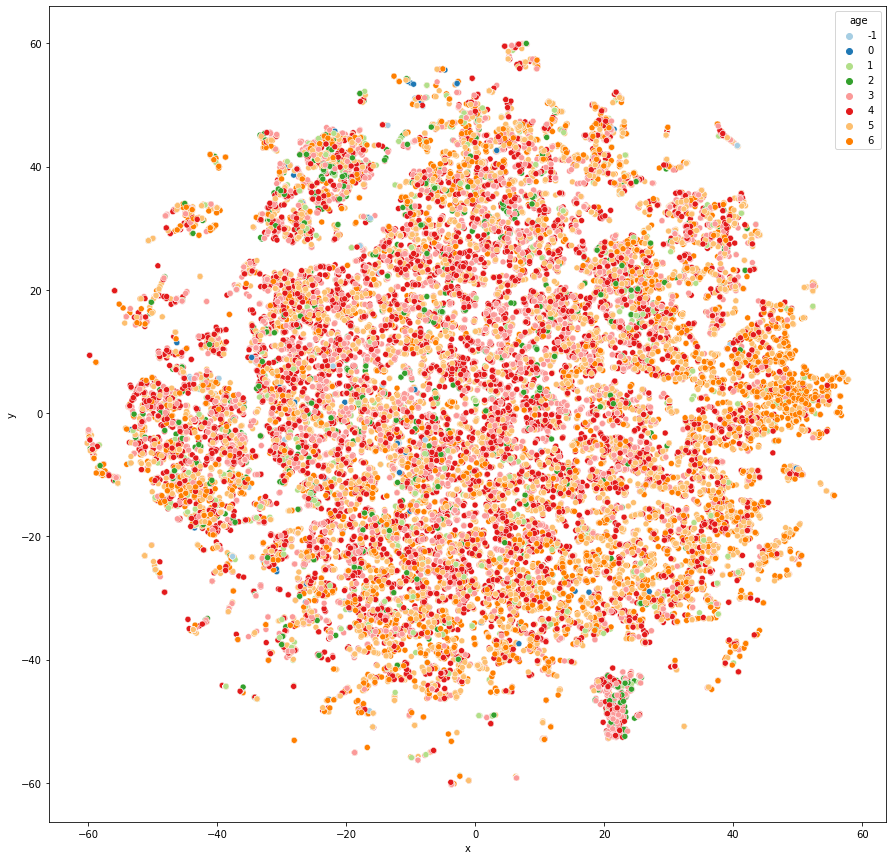

In [ ]:
# Visualization for TSNE model with learning_rate=100, n_iter=1000

import seaborn as sns
plt.figure(figsize=(15,15))
sns.scatterplot(data=df_tsne, x="x", y="y", hue="age", palette = 'Paired')

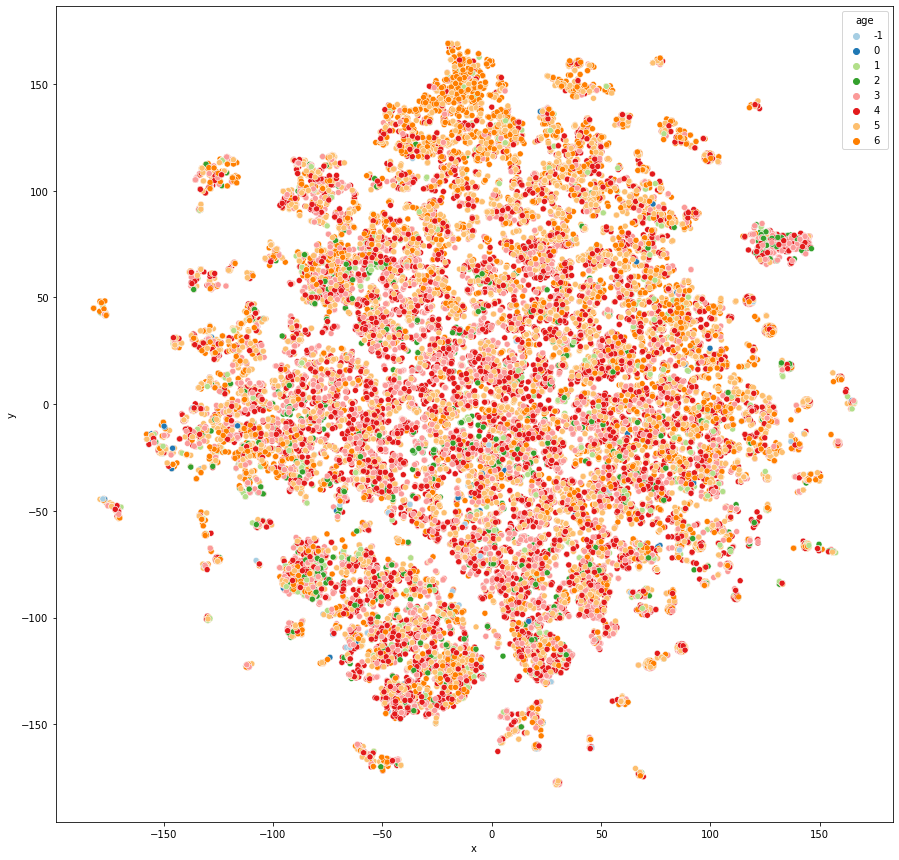

In [ ]:
# no obvious clustering, adjust parameters
# Visualization for TSNE model with learning_rate=100, n_iter=10000

model = TSNE(learning_rate=100, n_iter=10000)
Tsne_transformed = model.fit_transform(x_sample)

df_tsne = pd.DataFrame(Tsne_transformed)
df_tsne['age'] = sample_age
df_tsne.columns = ["x","y","age"]

plt.figure(figsize=(15,15))
sns.scatterplot(data=df_tsne, x="x", y="y", hue="age", palette = 'Paired')

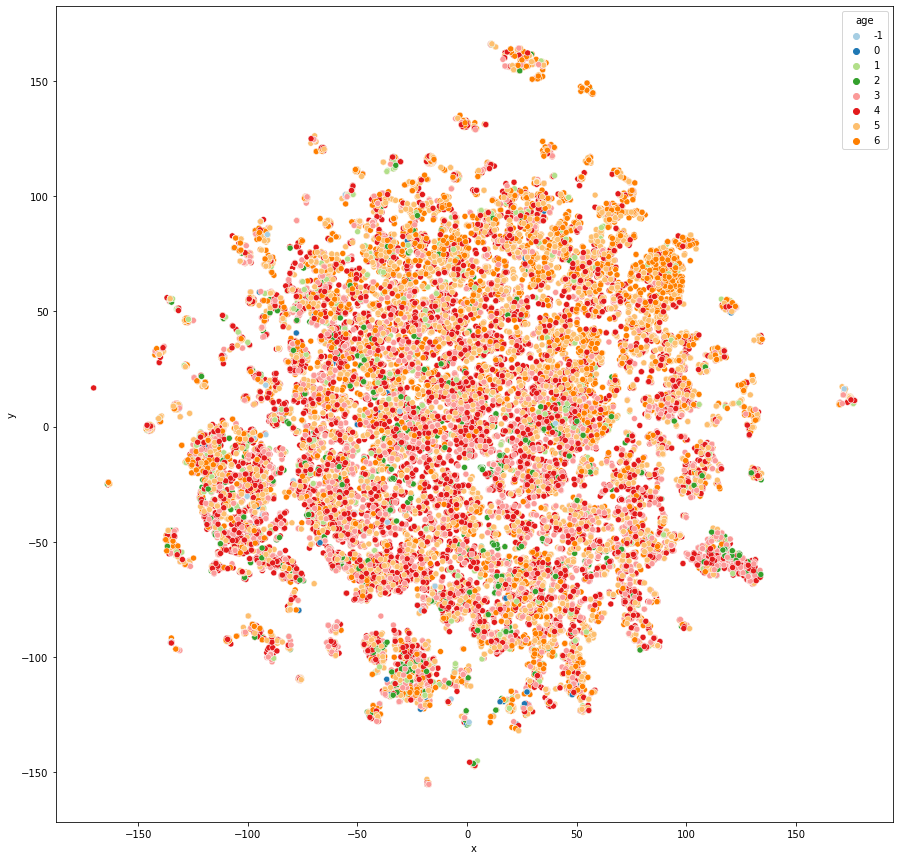

In [ ]:
# adjust parameters again
# Visualization for TSNE model with learning_rate=200, n_iter=3000

model = TSNE(learning_rate=200, n_iter=3000)
Tsne_transformed = model.fit_transform(x_sample)

df_tsne = pd.DataFrame(Tsne_transformed)
df_tsne['age'] = sample_age
df_tsne.columns = ["x","y","age"]

plt.figure(figsize=(15,15))
sns.scatterplot(data=df_tsne, x="x", y="y", hue="age", palette = 'Paired')


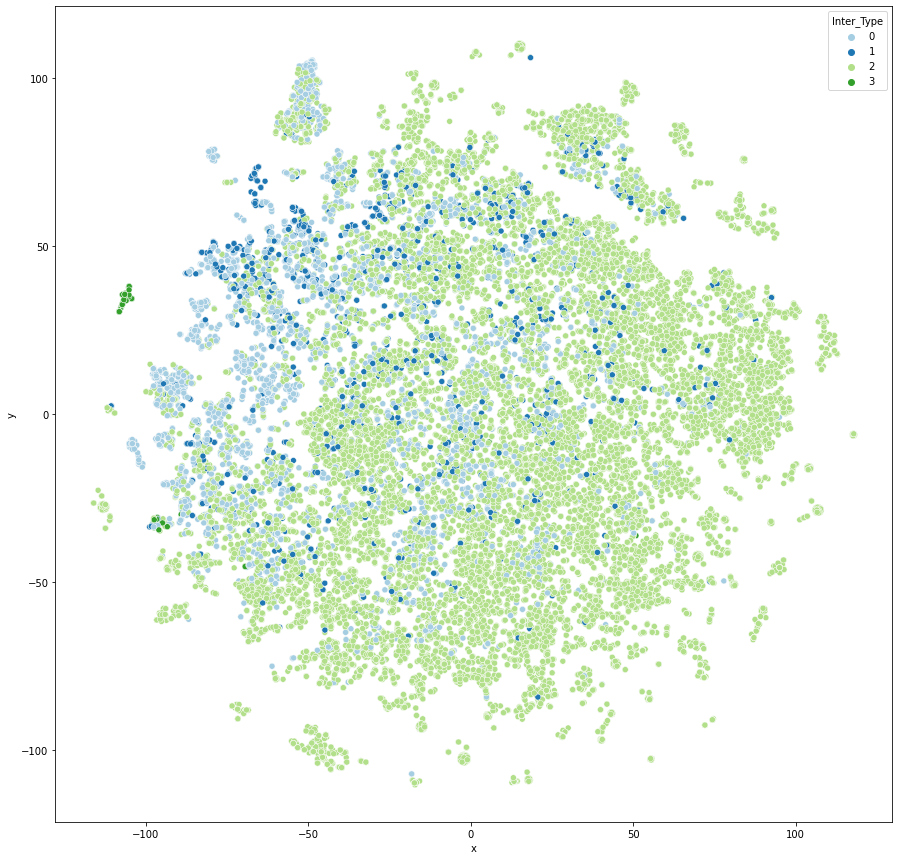

In [ ]:
# We try another feature and see if there is any obvious clustering
# choose 'inter_type_cd'
df_tsne = df_emb1[['uid_adv_id_emb_0', 'uid_adv_id_emb_1', 'uid_adv_id_emb_2', 'uid_adv_id_emb_3', 'uid_adv_id_emb_4', 'uid_adv_id_emb_5',
             'uid_adv_id_emb_6', 'uid_adv_id_emb_7', 'inter_type_cd']]
df_tsne.set_index("inter_type_cd",inplace=True)

# randomly select 1% of the original records since the original dataset was too large to run Tsne
x_sample = df_tsne.sample(frac=0.01,random_state=42)
x_sample

# Visualization for TSNE model with learning_rate=100, n_iter=2000
model = TSNE(learning_rate=100, n_iter=2000)
Tsne_transformed = model.fit_transform(x_sample)

sample_intertype = x_sample.index

df_tsne = pd.DataFrame(Tsne_transformed)
df_tsne['Inter_Type'] = sample_intertype
df_tsne.columns = ["x","y","Inter_Type"]

plt.figure(figsize=(15,15))
sns.scatterplot(data=df_tsne, x="x", y="y", hue="Inter_Type", palette = 'Paired')



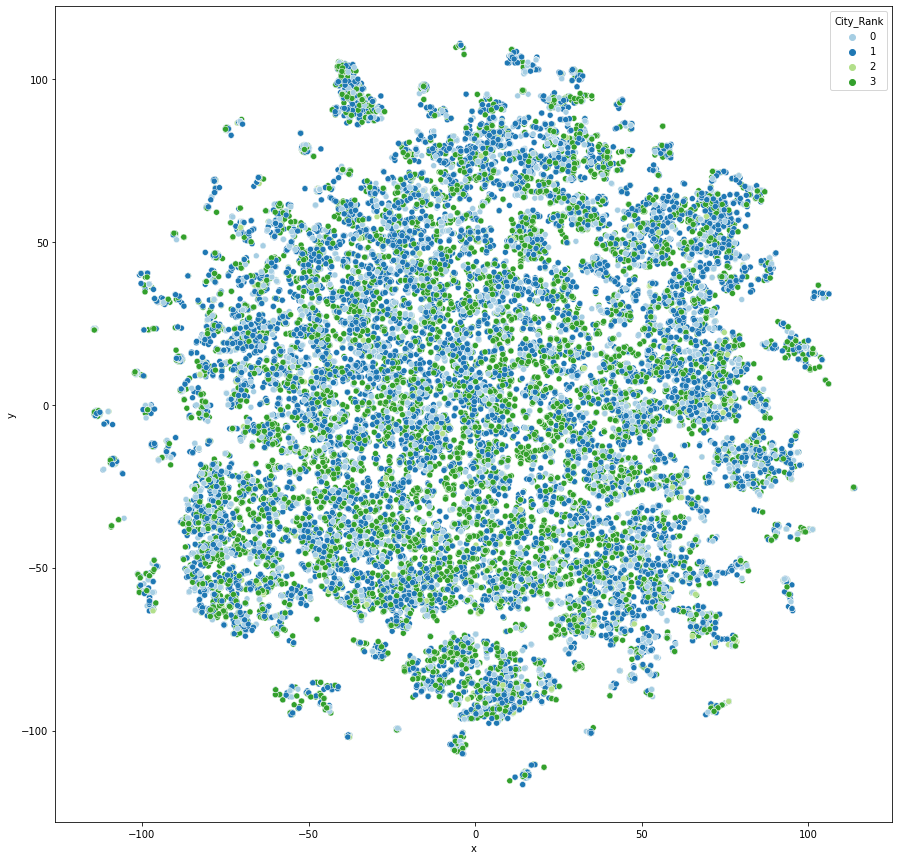

In [ ]:
# We try another feature and see if there is any obvious clustering
# choose 'city_rank'
df_tsne = df_emb1[['uid_adv_id_emb_0', 'uid_adv_id_emb_1', 'uid_adv_id_emb_2', 'uid_adv_id_emb_3', 'uid_adv_id_emb_4', 'uid_adv_id_emb_5',
             'uid_adv_id_emb_6', 'uid_adv_id_emb_7', 'city_rank']]
df_tsne.set_index("city_rank",inplace=True)

# randomly select 1% of the original records since the original dataset was too large to run Tsne
x_sample = df_tsne.sample(frac=0.01,random_state=42)
sample_cityrank = x_sample.index

# Visualization for TSNE model with learning_rate=100, n_iter=2000
model = TSNE(learning_rate=100, n_iter=2000)
Tsne_transformed = model.fit_transform(x_sample)

df_tsne = pd.DataFrame(Tsne_transformed)
df_tsne['City_Rank'] = sample_cityrank
df_tsne.columns = ["x","y","City_Rank"]

plt.figure(figsize=(15,15))
sns.scatterplot(data=df_tsne, x="x", y="y", hue="City_Rank", palette = 'Paired')


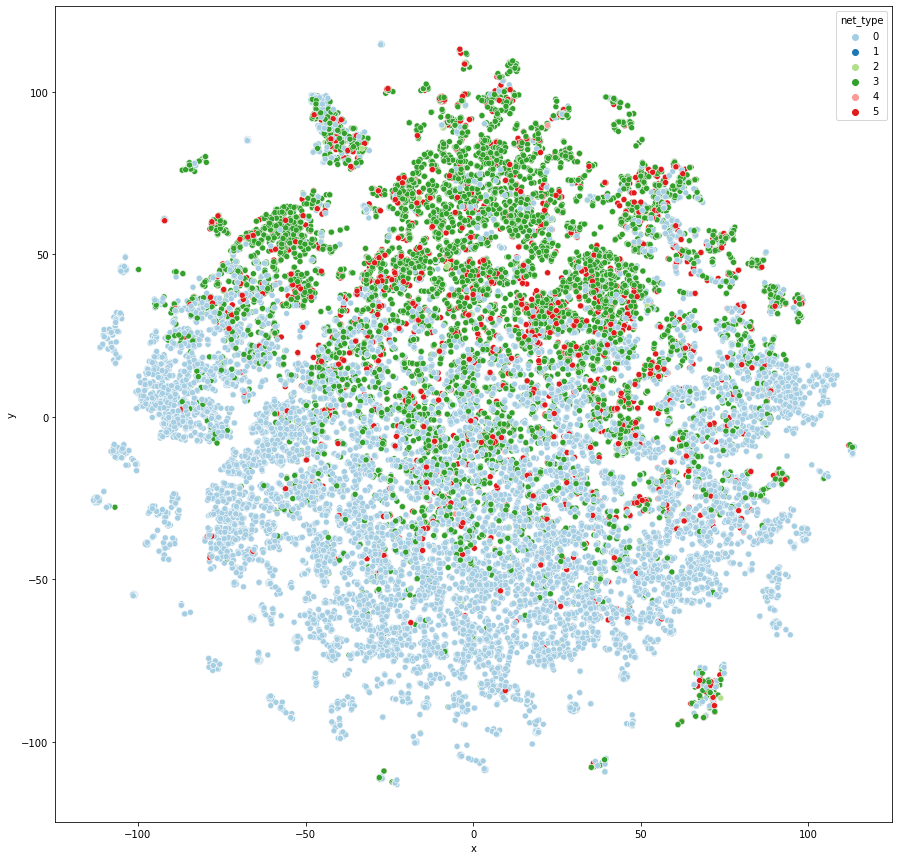

In [ ]:
# We try another feature and see if there is any obvious clustering
# choose 'net_type'
df_tsne = df_emb1[['uid_adv_id_emb_0', 'uid_adv_id_emb_1', 'uid_adv_id_emb_2', 'uid_adv_id_emb_3', 'uid_adv_id_emb_4', 'uid_adv_id_emb_5',
             'uid_adv_id_emb_6', 'uid_adv_id_emb_7', 'net_type']]
df_tsne.set_index("net_type",inplace=True)

# randomly select 1% of the original records since the original dataset was too large to run Tsne
x_sample = df_tsne.sample(frac=0.01,random_state=42)
sample_nettype = x_sample.index

# Visualization for TSNE model with learning_rate=100, n_iter=2000
model = TSNE(learning_rate=100, n_iter=2000)
Tsne_transformed = model.fit_transform(x_sample)

df_tsne = pd.DataFrame(Tsne_transformed)
df_tsne['net_type'] = sample_nettype
df_tsne.columns = ["x","y","net_type"]

plt.figure(figsize=(15,15))
sns.scatterplot(data=df_tsne, x="x", y="y", hue="net_type", palette = 'Paired')


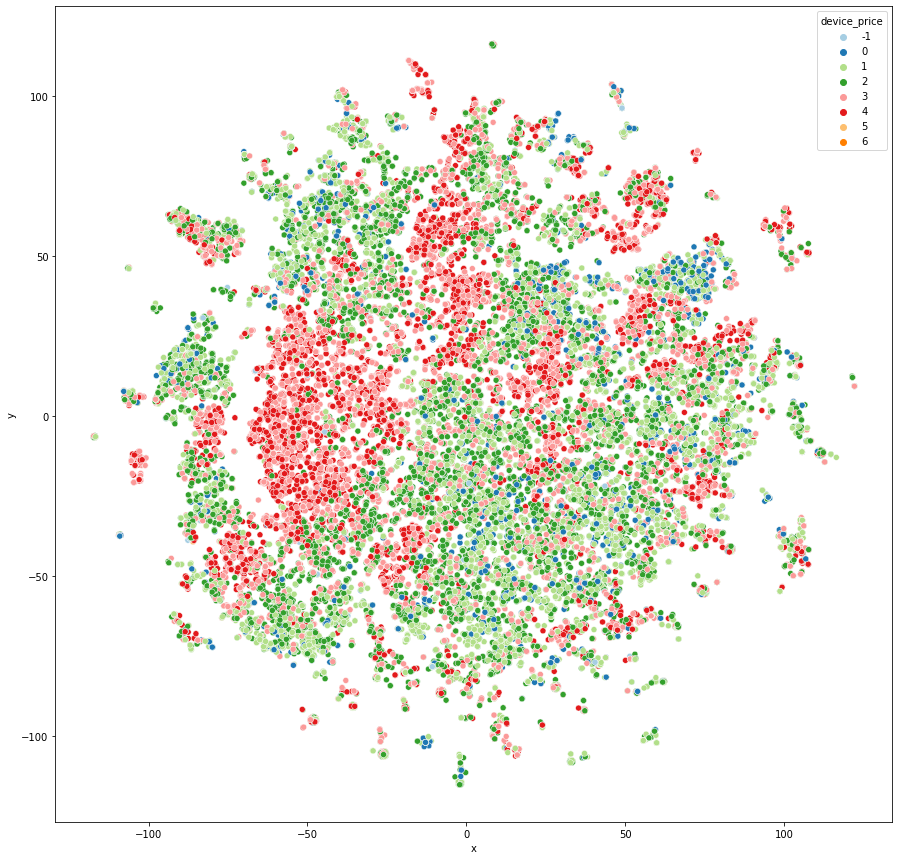

In [ ]:
# We try another feature and see if there is any obvious clustering
# choose 'device_price'
df_tsne = df_emb1[['uid_adv_id_emb_0', 'uid_adv_id_emb_1', 'uid_adv_id_emb_2', 'uid_adv_id_emb_3', 'uid_adv_id_emb_4', 'uid_adv_id_emb_5',
             'uid_adv_id_emb_6', 'uid_adv_id_emb_7', 'device_price']]
df_tsne.set_index("device_price",inplace=True)

# randomly select 1% of the original records since the original dataset was too large to run Tsne
x_sample = df_tsne.sample(frac=0.01,random_state=42)
sample_deviceprice = x_sample.index

# Visualization for TSNE model with learning_rate=100, n_iter=2000
model = TSNE(learning_rate=100, n_iter=2000)
Tsne_transformed = model.fit_transform(x_sample)

df_tsne = pd.DataFrame(Tsne_transformed)
df_tsne['device_price'] = sample_deviceprice
df_tsne.columns = ["x","y","device_price"]

plt.figure(figsize=(15,15))
sns.scatterplot(data=df_tsne, x="x", y="y", hue="device_price", palette = 'Paired')

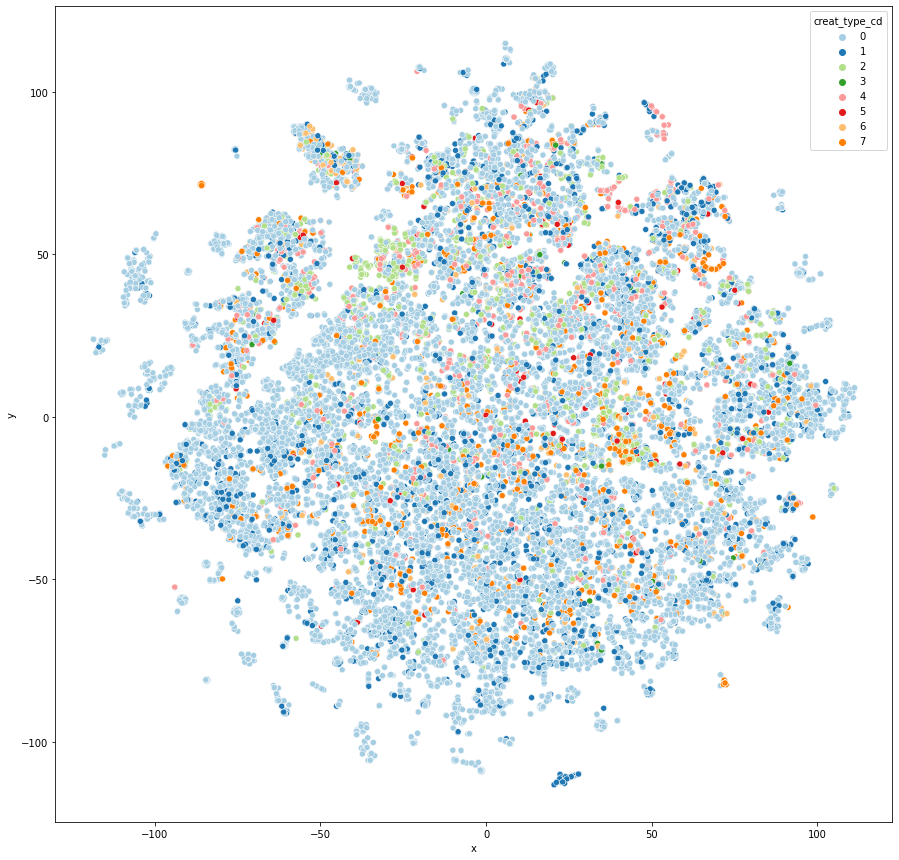

In [ ]:
# We try another feature and see if there is any obvious clustering
# choose 'creat_type_cd'
df_tsne = df_emb1[['uid_adv_id_emb_0', 'uid_adv_id_emb_1', 'uid_adv_id_emb_2', 'uid_adv_id_emb_3', 'uid_adv_id_emb_4', 'uid_adv_id_emb_5',
             'uid_adv_id_emb_6', 'uid_adv_id_emb_7', 'creat_type_cd']]
df_tsne.set_index("creat_type_cd",inplace=True)

# randomly select 1% of the original records since the original dataset was too large to run Tsne
x_sample = df_tsne.sample(frac=0.01,random_state=42)
sample_creattype = x_sample.index

# Visualization for TSNE model with learning_rate=100, n_iter=2000
model = TSNE(learning_rate=100, n_iter=2000)
Tsne_transformed = model.fit_transform(x_sample)

df_tsne = pd.DataFrame(Tsne_transformed)
df_tsne['creat_type_cd'] = sample_creattype
df_tsne.columns = ["x","y","creat_type_cd"]

plt.figure(figsize=(15,15))
sns.scatterplot(data=df_tsne, x="x", y="y", hue="creat_type_cd", palette = 'Paired')

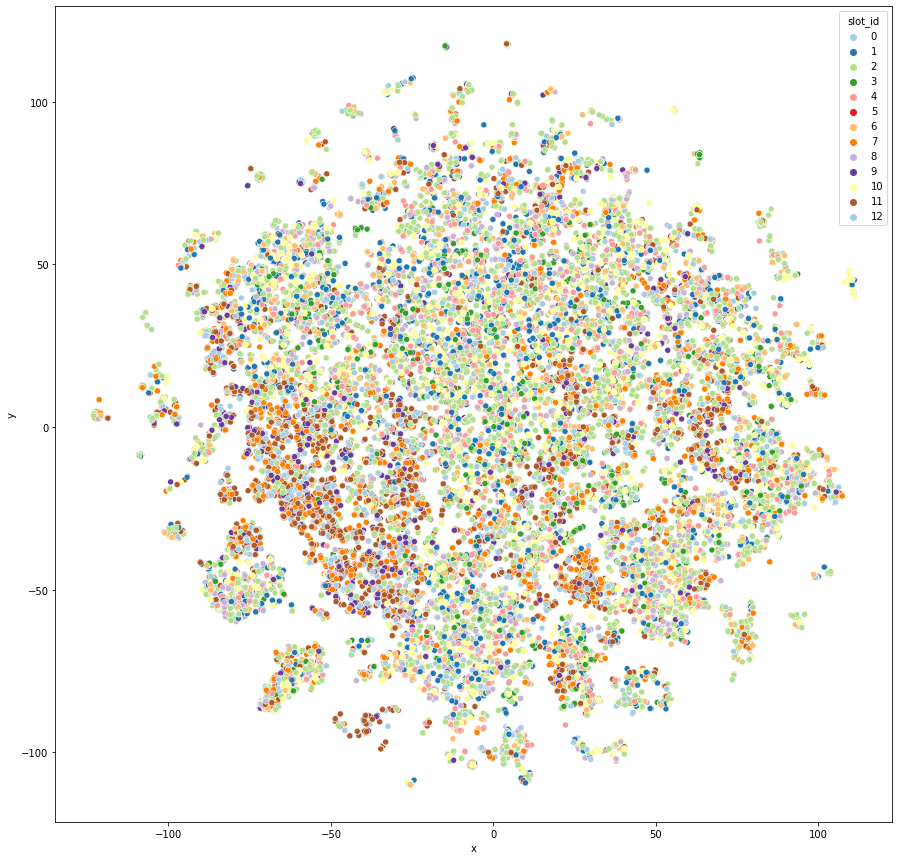

In [ ]:
# We try another feature and see if there is any obvious clustering
# choose 'device_price'
df_tsne = df_emb1[['uid_adv_id_emb_0', 'uid_adv_id_emb_1', 'uid_adv_id_emb_2', 'uid_adv_id_emb_3', 'uid_adv_id_emb_4', 'uid_adv_id_emb_5',
             'uid_adv_id_emb_6', 'uid_adv_id_emb_7', 'slot_id']]
df_tsne.set_index("slot_id",inplace=True)

# randomly select 1% of the original records since the original dataset was too large to run Tsne
x_sample = df_tsne.sample(frac=0.01,random_state=42)
sample_slot = x_sample.index

# Visualization for TSNE model with learning_rate=100, n_iter=2000
model = TSNE(learning_rate=100, n_iter=2000)
Tsne_transformed = model.fit_transform(x_sample)

df_tsne = pd.DataFrame(Tsne_transformed)
df_tsne['slot_id'] = sample_slot
df_tsne.columns = ["x","y","slot_id"]

plt.figure(figsize=(15,15))
sns.scatterplot(data=df_tsne, x="x", y="y", hue="slot_id", palette = 'Paired')

In [ ]:
# performing embedding again on uid vs ad- and app-related features, and adv_id vs user- and app-related features
for f1, f2 in tqdm([
    ['uid', 'adv_id'],
    ['uid', 'task_id'],
    ['uid', 'adv_prim_id'],
    ['uid', 'spread_app_id'],
    ['uid', 'tags'],
    ['uid', 'slot_id'],
    ['uid', 'net_type'],
    ['adv_id', 'spread_app_id'],
    ['adv_id', 'tags'],
    ['adv_id', 'device_name'],
    ['adv_id', 'residence'],
    ['adv_id', 'city_rank'],
    ['adv_id', 'age'],
    ['adv_id', 'slot_id'],
    ['adv_id', 'net_type']
]):
    df = embedding(df, f1, f2)

100%|██████████| 15/15 [13:53<00:00, 55.58s/it]


In [ ]:
#emb2 is exported to get_w2v_emb2.pkl
df.to_pickle('/content/drive/My Drive/data/get_w2v_emb2.pkl')

In [ ]:
gc.collect()

129

# Modeling

## Feature selection using lightGBM

In [ ]:
from statistics import mean
import gc
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from imblearn.over_sampling import SMOTE
# from utils import *
from tqdm import tqdm
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
tqdm.pandas(desc='pandas bar')
warnings.filterwarnings('ignore')

# modeling
import lightgbm as lgb
from sklearn.metrics import f1_score,precision_score,recall_score

In [ ]:
def feature_compare(df_train, df_validation, metric='auc'):
  '''a function to return the metric on validation set '''
  # set X train, y train, X validation and y validation data
  X_train, y_train = df_train.drop(['label'], axis=1), df_train['label']
  X_validation, y_validation = df_validation.drop(['label'], axis=1), df_validation['label']

  # use auc as metrics
  # define lgb model
  clf = lgb.LGBMClassifier(boosting_type='goss',objective = 'binary',metric = 'auc')
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_validation)
  y_pred_prob = clf.predict_proba(X_validation)[:,1]
  
  if metric =='auc':
    fpr, tpr, thresholds = metrics.roc_curve(y_validation, y_pred_prob)
    return(metrics.auc(fpr, tpr))
  if metric == 'f1_score':
    return(f1_score(y_validation, y_pred))
  if metric == 'recall_score':
    return(recall_score(y_validation, y_pred))
  if metric == 'precision_score':
    return(precision_score(y_validation, y_pred))

In [ ]:
# define the empty dataframe for metrics
comp = pd.DataFrame(index=['auc','f1_score','recall_score','precision_score'])
comp

Empty DataFrame
Columns: []
Index: [auc, f1_score, recall_score, precision_score]

### benchmark

In [ ]:
df = pd.read_pickle('/content/drive/My Drive/data/processing_newnew.pkl')
df = reduce_mem(df)
# seperate train and valid dataset
df_train = df[df.pt_d!=7]
df_validation = df[df.pt_d==7]
del df
gc.collect()

-- Mem. usage decreased to 134.47 Mb (83.2% reduction),time spend:0.05 min


69

In [ ]:
# sample label 0 rows by 50% to reduce imbalance problem
df_train = pd.concat([df_train[df_train.label==1], df_train[df_train.label==0].sample(frac=0.5, random_state=42)], ignore_index=True)
df_train.shape

(1334825, 35)

In [ ]:
# return four metrics on validation set
comp['benchmark'] = [feature_compare(df_train, df_validation,'auc'), feature_compare(df_train, df_validation,'f1_score'), 
                     feature_compare(df_train, df_validation,'recall_score'), feature_compare(df_train, df_validation,'precision_score')]

In [ ]:
comp

benchmark
auc               0.745632
f1_score          0.034324
recall_score      0.017904
precision_score   0.414219

### + stat features

In [ ]:
df = pd.read_pickle('/content/drive/My Drive/data/get_stat_newnew.pkl')
df = reduce_mem(df)
# seperate train and valid dataset
df_train = df[df.pt_d!=7]
df_validation = df[df.pt_d==7]
del df
gc.collect()

-- Mem. usage decreased to 663.76 Mb (59.7% reduction),time spend:0.18 min


0

In [ ]:
df_train.shape

(2570068, 101)

In [ ]:
# sample label 0 rows by 50% to reduce imbalance problem
df_train = pd.concat([df_train[df_train.label==1], df_train[df_train.label==0].sample(frac=0.5, random_state=42)], ignore_index=True)
df_train.shape

(1334825, 101)

In [ ]:
# return four metrics on validation set
comp['stat_feats'] = [feature_compare(df_train, df_validation,'auc'), feature_compare(df_train, df_validation,'f1_score'), 
                     feature_compare(df_train, df_validation,'recall_score'), feature_compare(df_train, df_validation,'precision_score')]

In [ ]:
comp

benchmark  stat_feats
auc               0.745632    0.764524
f1_score          0.034324    0.090728
recall_score      0.017904    0.051774
precision_score   0.414219    0.366430

### + ctr feature

In [ ]:
df = pd.read_pickle('/content/drive/My Drive/data/get_ctr_newnew.pkl')
df = reduce_mem(df)
# seperate train and valid dataset
df_train = df[df.pt_d!=7]
df_validation = df[df.pt_d==7]
del df
gc.collect()

-- Mem. usage decreased to 841.14 Mb (0.0% reduction),time spend:0.09 min


0

In [ ]:
# sample label 0 rows by 50% to reduce imbalance problem
df_train = pd.concat([df_train[df_train.label==1], df_train[df_train.label==0].sample(frac=0.5, random_state=42)], ignore_index=True)
df_train.shape

(1334825, 132)

In [ ]:
# return four metrics on validation set
comp['ctr_feats'] = [feature_compare(df_train, df_validation,'auc'), feature_compare(df_train, df_validation,'f1_score'), 
                     feature_compare(df_train, df_validation,'recall_score'), feature_compare(df_train, df_validation,'precision_score')]

comp

benchmark  stat_feats  ctr_feats
auc               0.745632    0.764524   0.712664
f1_score          0.034324    0.090728   0.176457
recall_score      0.017904    0.051774   0.547131
precision_score   0.414219    0.366430   0.105192

### + prev feature

In [ ]:
df = pd.read_pickle('/content/drive/My Drive/data/get_prev_ctr_newnew.pkl')
df = reduce_mem(df)
# seperate train and valid dataset
df_train = df[df.pt_d!=7]
df_validation = df[df.pt_d==7]
del df
gc.collect()

-- Mem. usage decreased to 1052.86 Mb (0.0% reduction),time spend:0.13 min


0

In [ ]:
# sample label 0 rows by 50% to reduce imbalance problem
df_train = pd.concat([df_train[df_train.label==1], df_train[df_train.label==0].sample(frac=0.5, random_state=42)], ignore_index=True)
df_train.shape

(1334825, 165)

In [ ]:
# return four metrics on validation set
comp['prev_ctr_feats'] = [feature_compare(df_train, df_validation,'auc'), feature_compare(df_train, df_validation,'f1_score'), 
                     feature_compare(df_train, df_validation,'recall_score'), feature_compare(df_train, df_validation,'precision_score')]


comp                     

benchmark  stat_feats  ctr_feats  prev_ctr_feats
auc               0.745632    0.764524   0.712664        0.711846
f1_score          0.034324    0.090728   0.176457        0.176512
recall_score      0.017904    0.051774   0.547131        0.546864
precision_score   0.414219    0.366430   0.105192        0.105240

### + w2v feature 1

In [ ]:
df = pd.read_pickle('/content/drive/My Drive/data/get_w2v_newnew.pkl')
df = reduce_mem(df)
# seperate train and valid dataset
df_train = df[df.pt_d!=7]
df_validation = df[df.pt_d==7]
del df
gc.collect()

-- Mem. usage decreased to 1098.63 Mb (0.0% reduction),time spend:0.14 min


0

In [ ]:
# sample label 0 rows by 50% to reduce imbalance problem
df_train = pd.concat([df_train[df_train.label==1], df_train[df_train.label==0].sample(frac=0.5, random_state=42)], ignore_index=True)
df_train.shape

(1334825, 173)

In [ ]:
# return four metrics on validation set
comp['w2v1_feats'] = [feature_compare(df_train, df_validation,'auc'), feature_compare(df_train, df_validation,'f1_score'), 
                     feature_compare(df_train, df_validation,'recall_score'), feature_compare(df_train, df_validation,'precision_score')]


comp                     

benchmark  stat_feats  ctr_feats  prev_ctr_feats  w2v1_feats
auc               0.745632    0.764524   0.712664        0.711846    0.711875
f1_score          0.034324    0.090728   0.176457        0.176512    0.176449
recall_score      0.017904    0.051774   0.547131        0.546864    0.546864
precision_score   0.414219    0.366430   0.105192        0.105240    0.105196

### +w2v 2

In [ ]:
df = pd.read_pickle('/content/drive/My Drive/data/get_w2v_emb2_newnew.pkl')
df = reduce_mem(df)
# seperate train and valid dataset
df_train = df[df.pt_d!=7]
df_validation = df[df.pt_d==7]
del df
gc.collect()

-- Mem. usage decreased to 1739.50 Mb (0.0% reduction),time spend:0.30 min


0

In [ ]:
# sample label 0 rows by 50% to reduce imbalance problem
df_train = pd.concat([df_train[df_train.label==1], df_train[df_train.label==0].sample(frac=0.5, random_state=42)], ignore_index=True)
df_train.shape

(1334825, 285)

In [ ]:
# return four metrics on validation set
comp['w2v2_feats'] = [feature_compare(df_train, df_validation,'auc'), feature_compare(df_train, df_validation,'f1_score'), 
                     feature_compare(df_train, df_validation,'recall_score'), feature_compare(df_train, df_validation,'precision_score')]


comp                     

benchmark  stat_feats  ctr_feats  prev_ctr_feats  w2v1_feats  \
auc               0.745632    0.764524   0.712664        0.711846    0.711875   
f1_score          0.034324    0.090728   0.176457        0.176512    0.176449   
recall_score      0.017904    0.051774   0.547131        0.546864    0.546864   
precision_score   0.414219    0.366430   0.105192        0.105240    0.105196   

                 w2v2_feats  
auc                0.710498  
f1_score           0.176719  
recall_score       0.546596  
precision_score    0.105397

### visualize

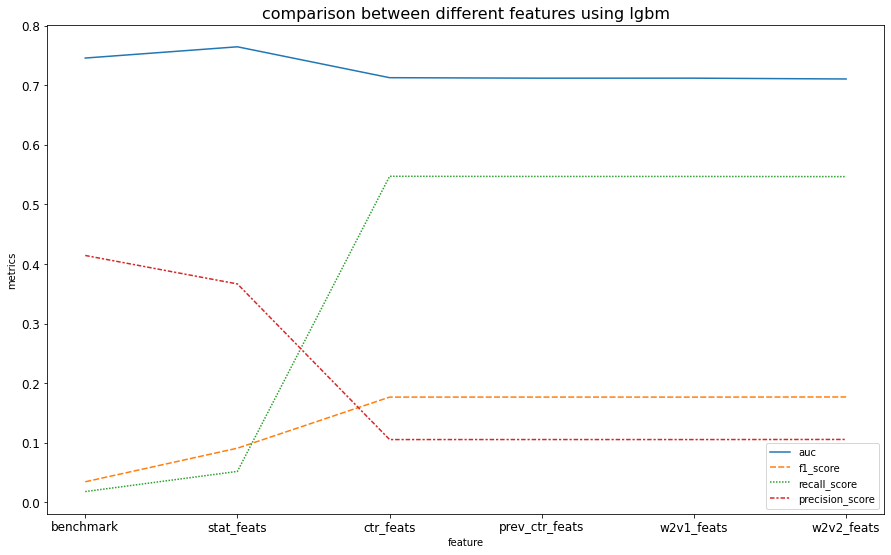

In [ ]:
plt.figure(figsize=(15,9))
sns.lineplot(data=comp.T)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('feature')
plt.ylabel('metrics')
plt.title('comparison between different features using lgbm', fontsize=16)
plt.savefig('/content/drive/My Drive/data/comparison.png')

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df_rfc = pd.read_pickle('get_w2v_newnew.pkl')

In [ ]:
df_train = df_rfc[df_rfc.pt_d!=7]
df_validation = df_rfc[df_rfc.pt_d==7]

In [ ]:
# manually split train and test data set into 80:20
df_train_sample = df_train.sample(n = 200000, random_state = 777)
df_validation_sample = df_validation.sample(n = 50000, random_state = 777)

In [ ]:
X_train = df_train_sample.drop(['label'], axis = 1)
y_train = df_train_sample['label']

In [ ]:
X_validation = df_validation_sample.drop(['label'], axis = 1)
y_validation = df_validation_sample['label']

In [ ]:
# create a model
rfc = RandomForestClassifier(random_state = 777)

# fit the model with data
rfc.fit(X_train, y_train)

# predict y_pred
y_pred = rfc.predict(X_validation)
y_pred_prob = rfc.predict_proba(X_validation)[:,1]

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_validation, y_pred_prob)
print('auc',metrics.auc(fpr, tpr))
print('f1', f1_score(y_validation, y_pred))
print('recall', recall_score(y_validation, y_pred))
print('precision', precision_score(y_validation, y_pred))

auc 0.6842407160272086
f1 0.015015015015015017
recall 0.008488964346349746
precision 0.06493506493506493


## Hyperparameter Tuning

In [ ]:
#df = pd.read_pickle('/content/drive/My Drive/data/get_stat_newnew.pkl')
#df = pd.read_pickle('/content/drive/My Drive/data/get_prev_ctr_newnew.pkl')
df = pd.read_pickle('/content/drive/My Drive/data/get_w2v_newnew.pkl')
df_train = df[df.pt_d!=7]
df_validation = df[df.pt_d==7]

df_train = pd.concat([df_train[df_train.label==1], df_train[df_train.label==0].sample(frac=0.5, random_state=42)], ignore_index=True)

del df
gc.collect()

11

In [ ]:
X_train,y_train=df_train.drop(['label'],axis=1),df_train['label']

In [ ]:
X_validation,y_validation=df_validation.drop(['label'],axis=1),df_validation['label']

In [ ]:
del df_train
del df_validation
gc.collect()

203

In [ ]:
def LGB_bayesian(num_leaves,min_data_in_leaf, learning_rate,min_sum_hessian_in_leaf,feature_fraction,lambda_l1,lambda_l2,min_gain_to_split,max_depth):
  num_leaves = int(num_leaves)
  min_data_in_leaf = int(min_data_in_leaf)
  max_depth = int(max_depth)
  assert type(num_leaves) == int
  assert type(min_data_in_leaf) == int
  assert type(max_depth) == int

  param = {
  'num_leaves': num_leaves,
  'objective' : 'binary',
  'max_bin' : 200,
  'min_data_in_leaf': min_data_in_leaf,
  'learning_rate': 0.05,
  'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
  'bagging_fraction': 1.0,
  'bagging_freq': 5,
  'feature_fraction': feature_fraction,
  'lambda_l1': lambda_l1,
  'lambda_l2': lambda_l2,
  'min_gain_to_split': min_gain_to_split,
  'max_depth': max_depth,
  'save_binary': True,
  'seed': 1337,
  'feature_fraction_seed': 1337,
  'bagging_seed': 1337,
  'drop_seed': 1337,
  'data_random_seed': 1337,
  'objective': 'binary',
  'boosting_type': 'gbdt',
  'verbose': 1,
  'metric': 'auc',
  'is_unbalance': True,
  'boost_from_average': True,
  'train_metric' : True,
  'colsample_bytree': 0.5,
  'min_child_samples': 15,
  'min_child_weight': 0,
  'subsample_for_bin': 200000,
  'nthread': 20,
  'verbose': 0
  }
  xg_train = lgb.Dataset(X_train,y_train)
  xg_valid  = lgb.Dataset(X_validation,y_validation)
  num_round = 5000
  clf = lgb.train(param, xg_train, num_round, valid_sets = [xg_valid], verbose_eval=250, early_stopping_rounds = 50)
  predictions = clf.predict(X_validation, num_iteration=clf.best_iteration)
  score = metrics.roc_auc_score(y_validation, predictions)
  return score


In [ ]:
bounds_LGB = {
'num_leaves': (50, 256),
'min_data_in_leaf': (5, 20),
'learning_rate': (0.01, 0.3),
'min_sum_hessian_in_leaf': (0.00001, 0.01),
'feature_fraction': (0.05, 0.5),
'lambda_l1': (0, 5.0),
'lambda_l2': (0, 5.0),
'min_gain_to_split': (0, 1.0),
'max_depth':(8,20)
}

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=0b42617bb43f0a60b210d94e4b404c61b8a0ce008e9a08bd8d37e993dee05da9
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [ ]:
from bayes_opt import BayesianOptimization
LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=13)

In [ ]:
print(LGB_BO.space.keys)

['feature_fraction', 'lambda_l1', 'lambda_l2', 'learning_rate', 'max_depth', 'min_data_in_leaf', 'min_gain_to_split', 'min_sum_hessian_in_leaf', 'num_leaves']


In [ ]:
init_points = 5
n_iter = 5
print('-' * 130)

with warnings.catch_warnings():
  warnings.filterwarnings('ignore')
  LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | min_ga... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	valid_0's auc: 0.779878
|  1        |  0.7799   |  0.4      |  1.188    |  4.121    |  0.2901   |  19.67    |  11.8     |  0.609    |  0.007758 |  182.2    |
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[3]	valid_0's auc: 0.779057
|  2        |  0.7791   |  0.3749   |  0.1752   |  1.492    |  0.02697  |  18.28    |  10.59    |  0.6798   |  0.00257  |  121.6    |
Training until validation scores don't improve for 50 rounds.
Early stopping, best 

In [ ]:
LGB_BO.max['target']

0.795475982614576

In [ ]:
LGB_BO.max['params']

{'feature_fraction': 0.05423574653643624,
 'lambda_l1': 1.7916689135248487,
 'lambda_l2': 4.745470908391052,
 'learning_rate': 0.07319071264818977,
 'max_depth': 11.832696396564375,
 'min_data_in_leaf': 18.76658579000881,
 'min_gain_to_split': 0.03190366643989473,
 'min_sum_hessian_in_leaf': 0.0006601945250547198,
 'num_leaves': 179.74477381621153}

In [ ]:
# GBDT Parameter

In [ ]:
  
  param_lgb = {
  'num_leaves': int(LGB_BO.max['params']['num_leaves']),
  'objective' : 'binary',
  'max_bin' : 200,
  'min_data_in_leaf': int(LGB_BO.max['params']['min_data_in_leaf']),
  'learning_rate': 0.05,
  'min_sum_hessian_in_leaf': LGB_BO.max['params']['min_sum_hessian_in_leaf'],
  'bagging_fraction': 1.0,
  'bagging_freq': 5,
  'feature_fraction': LGB_BO.max['params']['feature_fraction'],
  'lambda_l1': LGB_BO.max['params']['lambda_l1'],
  'lambda_l2': LGB_BO.max['params']['lambda_l2'],
  'min_gain_to_split': LGB_BO.max['params']['min_gain_to_split'],
  'max_depth': int(LGB_BO.max['params']['max_depth']),
  'save_binary': True,
  'seed': 1337,
  'feature_fraction_seed': 1337,
  'bagging_seed': 1337,
  'drop_seed': 1337,
  'data_random_seed': 1337,
  'objective': 'binary',
  'boosting_type': 'gbdt',
  'verbose': 1,
  'metric': 'auc',
  'is_unbalance': True,
  'boost_from_average': True,
  'train_metric' : True,
  'colsample_bytree': 0.5,
  'min_child_samples': 15,
  'min_child_weight': 0,
  'subsample_for_bin': 200000,
  'nthread': 20,
  'verbose': 0
  }

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train)

In [ ]:
lgb_valid = lgb.Dataset(X_validation, y_validation)

In [ ]:
clf = lgb.train(param_lgb, lgb_train, 5000, valid_sets = [lgb_valid], verbose_eval=250, early_stopping_rounds = 50)



Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[133]	valid_0's auc: 0.795476


In [ ]:
predictions = clf.predict(X_validation)
score = metrics.roc_auc_score(y_validation, predictions)
score


0.795475982614576

In [ ]:
print(param_lgb)

{'num_leaves': 179, 'objective': 'binary', 'max_bin': 200, 'min_data_in_leaf': 18, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.0006601945250547198, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.05423574653643624, 'lambda_l1': 1.7916689135248487, 'lambda_l2': 4.745470908391052, 'min_gain_to_split': 0.03190366643989473, 'max_depth': 11, 'save_binary': True, 'seed': 1337, 'feature_fraction_seed': 1337, 'bagging_seed': 1337, 'drop_seed': 1337, 'data_random_seed': 1337, 'boosting_type': 'gbdt', 'verbose': 0, 'metric': 'auc', 'is_unbalance': True, 'boost_from_average': True, 'train_metric': True, 'colsample_bytree': 0.5, 'min_child_samples': 15, 'min_child_weight': 0, 'subsample_for_bin': 200000, 'nthread': 20}


In [ ]:
# Same Parameter for goss 

In [ ]:
  param_goss = {
  'num_leaves': int(LGB_BO.max['params']['num_leaves']),
  'objective' : 'binary',
  'max_bin' : 200,
  'min_data_in_leaf': int(LGB_BO.max['params']['min_data_in_leaf']),
  'learning_rate': 0.05,
  'min_sum_hessian_in_leaf': LGB_BO.max['params']['min_sum_hessian_in_leaf'],
  'bagging_fraction': 1.0,
  'bagging_freq': 5,
  'feature_fraction': LGB_BO.max['params']['feature_fraction'],
  'lambda_l1': LGB_BO.max['params']['lambda_l1'],
  'lambda_l2': LGB_BO.max['params']['lambda_l2'],
  'min_gain_to_split': LGB_BO.max['params']['min_gain_to_split'],
  'max_depth': int(LGB_BO.max['params']['max_depth']),
  'save_binary': True,
  'seed': 1337,
  'feature_fraction_seed': 1337,
  'bagging_seed': 1337,
  'drop_seed': 1337,
  'data_random_seed': 1337,
  'objective': 'binary',
  'boosting_type': 'goss', # except here
  'verbose': 1,
  'metric': 'auc',
  'is_unbalance': True,
  'boost_from_average': True,
  'train_metric' : True,
  'colsample_bytree': 0.5,
  'min_child_samples': 15,
  'min_child_weight': 0,
  'subsample_for_bin': 200000,
  'nthread': 20,
  'verbose': 0
  }

In [ ]:
clf_goss = lgb.train(param_goss, lgb_train, 5000, valid_sets = [lgb_valid], verbose_eval=250, early_stopping_rounds = 50)


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[133]	valid_0's auc: 0.794755


In [ ]:
predictions = clf_goss.predict(X_validation)
score = metrics.roc_auc_score(y_validation, predictions)
score

0.7947553838822932

In [ ]:
print(param_goss)

{'num_leaves': 179, 'objective': 'binary', 'max_bin': 200, 'min_data_in_leaf': 18, 'learning_rate': 0.05, 'min_sum_hessian_in_leaf': 0.0006601945250547198, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.05423574653643624, 'lambda_l1': 1.7916689135248487, 'lambda_l2': 4.745470908391052, 'min_gain_to_split': 0.03190366643989473, 'max_depth': 11, 'save_binary': True, 'seed': 1337, 'feature_fraction_seed': 1337, 'bagging_seed': 1337, 'drop_seed': 1337, 'data_random_seed': 1337, 'boosting_type': 'goss', 'verbose': 0, 'metric': 'auc', 'is_unbalance': True, 'boost_from_average': True, 'train_metric': True, 'colsample_bytree': 0.5, 'min_child_samples': 15, 'min_child_weight': 0, 'subsample_for_bin': 200000, 'nthread': 20}


In [ ]:
parameter_df = pd.DataFrame(param_goss.values(),index=param_goss.keys(),columns=['Hyperparameter Value'])

In [ ]:
parameter_df.drop(['seed','feature_fraction_seed','bagging_seed','drop_seed','data_random_seed'])

Hyperparameter Value
num_leaves                               179
objective                             binary
max_bin                                  200
min_data_in_leaf                          18
learning_rate                           0.05
min_sum_hessian_in_leaf              0.00066
bagging_fraction                         1.0
bagging_freq                               5
feature_fraction                    0.054236
lambda_l1                           1.791669
lambda_l2                           4.745471
min_gain_to_split                   0.031904
max_depth                                 11
save_binary                             True
boosting_type                           goss
verbose                                    0
metric                                   auc
is_unbalance                            True
boost_from_average                      True
train_metric                            True
colsample_bytree                         0.5
min_child_samples                         15
min_child_weight                           0
subsample_for_bin                     200000
nthread                                   20

## Feature importance

In [ ]:
df = pd.read_pickle('/content/drive/My Drive/data/get_w2v_newnew.pkl')
df = reduce_mem(df)
# seperate train and valid dataset
df_train = df[df.pt_d!=7]
df_validation = df[df.pt_d==7]
del df
gc.collect()

# sample label 0 rows by 50% to reduce imbalanced problem
df_train = pd.concat([df_train[df_train.label==1], df_train[df_train.label==0].sample(frac=0.5, random_state=42)], ignore_index=True)
df_train.shape

# set X train, y train, X validation and y validation data
X_train, y_train = df_train.drop(['label'], axis=1), df_train['label']
X_validation, y_validation = df_validation.drop(['label'], axis=1), df_validation['label']

-- Mem. usage decreased to 1098.63 Mb (0.0% reduction),time spend:0.16 min


In [ ]:
# run on best paramerters and features
clf = lgb.LGBMClassifier(num_leaves=179, objective='binary',
                         max_bin=200, min_data_in_leaf=18, 
                         learning_rate=0.05, 
                         min_sum_hessian_in_leaf=0.0006601945250547198, 
                         bagging_fraction=1.0, bagging_freq=5, 
                         feature_fraction=0.05423574653643624,
                         lambda_l1=1.7916689135248487, 
                         lambda_l2=4.745470908391052, 
                         min_gain_to_split=0.03190366643989473,
                         max_depth=11, save_binary=True, seed=1337, 
                         feature_fraction_seed=1337, bagging_seed=1337, 
                         drop_seed=1337, data_random_seed=1337, 
                         boosting_type='goss', verbose=0, metric= 'auc', 
                         is_unbalance=True, boost_from_average=True, 
                         train_metric=True, colsample_bytree=0.5, 
                         min_child_samples=15, min_child_weight=0, 
                         subsample_for_bin=200000, nthread=20)
 
clf.fit(X_train, y_train)

y_pred = clf.predict(X_validation)
y_pred_prob = clf.predict_proba(X_validation)[:,1]

In [ ]:
# get metrics for best model
fpr, tpr, thresholds = metrics.roc_curve(y_validation, y_pred_prob)
print(metrics.auc(fpr, tpr))

print(f1_score(y_validation, y_pred))

print(recall_score(y_validation, y_pred))
print(precision_score(y_validation, y_pred))

0.7944359598977964
0.18361413448635752
0.6581601977420002
0.1066891913842955


In [ ]:
# get feature importance
feature_imp = pd.DataFrame({'features':X_train.columns, 'importance':clf.feature_importances_.flatten()}).sort_values(by='importance', ascending=False)
feature_imp

features  importance
27                     adv_id         540
166          uid_adv_id_emb_2         537
76   net_type_in_adv_id_ratio         368
20                adv_prim_id         318
83    slot_id_in_adv_id_ratio         309
..                        ...         ...
116            online_end_ctr          11
98                    uid_ctr          10
1                   city_rank           3
4           his_on_shelf_time           3
64             emui_dev_count           0

[172 rows x 2 columns]

In [ ]:
feature_imp.to_csv('/content/drive/My Drive/data/lightgbm_feature_importance.csv')

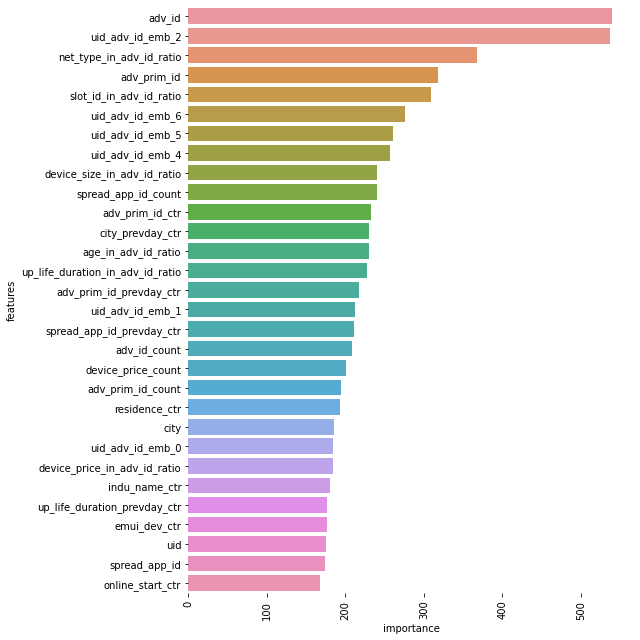

In [ ]:
# only visualize top 30 features
feature_imp = pd.read_csv('/content/drive/My Drive/data/lightgbm_feature_importance.csv')
plt.figure(figsize=(9,9))
plt.box(False)
sns.barplot(x='importance',y='features', data=feature_imp.iloc[:30,])
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/data/top30features.png')